*This notebook contains code and explanation to create S5000F XSD from Enterprise Architect XMI download.*

# PREPARATION

**01 – Notebooks links**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

**02 - Import libraries**

In [53]:
import pandas as pd
import numpy as np
from lxml import etree
from pathlib import Path

**03 - Locate XMI and XSD files**

In [ ]:
# locate directories
xmi = Path() / "UML model"            # directory containing XMI files downloaded from Entreprise Architect
xsd = Path()/ "S5000F_4-0"            # directory containing S5000F XML Schema files
res = Path() / "Results"              # directory containing generated XSD files
# locate files
cdm = xmi / "SX002D_Data_model.xml"
s5f = xmi / "S5000F_Data_model_75BR.xml"
isfDataset = xsd / "s5000f_4-0_isfDataset.xsd"
validValues = xsd / "s5000f_4-0_valid_values.xsd"

print(s5f)       # Check s5f relative filepath

**04 - Common functions**

In [ ]:
def get_namespaces(xsd_path):
    """
    Collect namespaces from an XSD file.
    Args:      xsd_path (str):    Relative filepath of XML file to be processed.
    Returns:   ns (dict):         A dictionary where keys are prefixes and values are namespace URIs.
    """
    ns = {}
    try:
        tree = etree.parse(xsd_path)
        root = tree.getroot()
        ns = root.nsmap               
    except etree.XMLSyntaxError as e:
        print(f"Error parsing XSD file: {e}")
    except FileNotFoundError:
        print(f"File not found: {xsd_path}")
    return ns

# XML Metadata Interchange (XMI)
*UML data model is downloaded from Enterprise Architect using XML Metadata Interchange (XMI) version 2.1. This download is done from package:<ul><li><b>S-Series_SX002D_Data_model</b> (source identified as SX001G)<li><b>S_Series_S5000F</b> (source identified as S5000F)*

## Connectors
Information about uml connector is located at xpath **/xmi:XMI/xmi:Extension/connectors/** in xmi files

### Function xmi_connectors

In [5]:
def xmi_connectors(*files):
    """
    Function which collects information about connectors from XMI files downloaded from Enterprise Architect:
        conn_id        /xmi:XMI/xmi:Extension/connectors/connector/@xmi:idref
        conn_type      /xmi:XMI/xmi:Extension/connectors/connector/properties/@ea_type
        conn_direction /xmi:XMI/xmi:Extension/connectors/connector/properties/@direction
        start_id       /xmi:XMI/xmi:Extension/connectors/connector/source/@xmi:idref
        start_type     /xmi:XMI/xmi:Extension/connectors/connector/source/model/@type
        start_name     /xmi:XMI/xmi:Extension/connectors/connector/source/model/@name
        end_id         /xmi:XMI/xmi:Extension/connectors/connector/target/@xmi:idref
        end_type       /xmi:XMI/xmi:Extension/connectors/connector/target/model/@type
        end_name       /xmi:XMI/xmi:Extension/connectors/connector/target/model/@name      
    Input:         list of XMI file to be analyzed
    Output:        Dataframe df(conn_id, conn_type, conn_direction,
                                start_id, start_type, start_name,
                                end_id, end_type, end_name,
                                source)

                                /xmi:XMI/xmi:Extension/connectors/connector[1]/source/model/@type
/xmi:XMI/xmi:Extension/connectors/connector[1]/source/model/@name
    """
    if not files:
        raise ValueError("At least one file must be provided.")
    
    rows = []
    for file in files:
        source = Path(file.name).stem
        ns = get_namespaces(file)  # Ensure get_namespaces is implemented correctly
        xmi = '{' + ns['xmi'] + '}'

        idref = xmi + 'idref'
        type = xmi + 'type'

        context = etree.iterparse(file, events=('end',), tag=('connector',))
        
        for event, elem in context:                               # Iterate over element closing tags
            conn_id = elem.attrib.get(idref)
            conn_name = elem.xpath('./properties',namespaces=ns)[0].get('ea_type')
            conn_dir = elem.xpath('./properties',namespaces=ns)[0].get('direction')
            start_id = elem.xpath('./source',namespaces=ns)[0].get(idref)
            start_type = elem.xpath('./source/model',namespaces=ns)[0].get('type')
            start_name = elem.xpath('./source/model',namespaces=ns)[0].get('name')
            end_id = elem.xpath('./target',namespaces=ns)[0].get(idref)
            end_type = elem.xpath('./target/model',namespaces=ns)[0].get('type')
            end_name = elem.xpath('./target/model',namespaces=ns)[0].get('name')

            
            rows.append({'Conn_Identifier': conn_id,'Conn_Type': conn_name, 'Conn_Direction': conn_dir,
                         'Start_Identifier': start_id, 'Start_Type': start_type, 'Start_Name': start_name,
                         'End_Identifier': end_id, 'End_Type': end_type, 'End_Name': end_name,
                         'source':source})
            elem.clear()
        

        df = pd.DataFrame(rows,columns=['Conn_Identifier','Conn_Type', 'Conn_Direction',
                                        'Start_Identifier', 'Start_Type', 'Start_Name',
                                        'End_Identifier', 'End_Type', 'End_Name',
                                        'source'])
    return df

### Collect information about uml connectors

In [6]:
s5f_connectors = xmi_connectors(s5f)
cdm_connectors = xmi_connectors(cdm)
all_connectors = xmi_connectors(s5f,cdm)

s5f_connectors['Conn_Type'] = s5f_connectors['Conn_Type'].astype(str)

# Save result in excel file Connectors.xlsx
with pd.ExcelWriter("Connectors.xlsx", engine="openpyxl") as writer:
    s5f_connectors.to_excel(writer, sheet_name="s5f", index=False)
    cdm_connectors.to_excel(writer, sheet_name="cdm", index=False)
    all_connectors.to_excel(writer, sheet_name="s5f & cdm", index=False)


### Analyse collected information about uml connectors

In [7]:
# Identify number of connectors by type
s5f_connector_type = s5f_connectors.groupby(['Conn_Type']).size()
cdm_connector_type = cdm_connectors.groupby(['Conn_Type']).size()
all_connector_type = all_connectors.groupby(['Conn_Type']).size()

# Combine into a dataframe
connector_summary = pd.DataFrame({'S5F': s5f_connector_type,
                                  'CDM': cdm_connector_type,
                                  'All': all_connector_type}).fillna(0)  # Fill missing values with 0.0 not an integer !

# Convert all columns to integers to remove 0.0 values and get an integer as counting result
connector_summary = connector_summary.astype(int).sort_values(by=['All'],ascending=False)

# Display the DataFrame
connector_summary.head(10)

,S5F,CDM,All
Conn_Type,,,
Aggregation,8625,1762,10387
Realisation,572,1471,2043
Association,350,421,771
Generalization,201,281,482
NoteLink,6,7,13
Abstraction,1,1,2
Dependency,0,1,1


## Classes and Attributes

### Function xmi_classes_attributes

In [8]:
def xmi_classes_attributes(*files):
    """
    Function to collect class and attribute information from XMI files.
    Outputs a DataFrame with common columns: 'name', 'xmlName', 'documentation',
    'identifier', 'stereotype', 'lower', and 'upper'.
    """
    if not files:
        raise ValueError("At least one file must be provided.")
    
    rows = []
    for file in files:
        source = Path(file.name).stem
        ns = get_namespaces(file)  # Ensure get_namespaces is implemented correctly
        xmi = '{' + ns['xmi'] + '}'

        context = etree.iterparse(file, events=('end',), tag=('element',))
        type_attr = xmi + 'type'

        for event, elem in context:
            if elem.attrib.get(type_attr) == 'uml:Class':
                # Collect class information
                class_name = elem.attrib.get('name', '')
                class_id = elem.attrib.get(f'{xmi}idref', '')
                class_doc = elem.xpath('./properties/@documentation', namespaces=ns)
                class_stereotype = elem.xpath('./properties/@stereotype', namespaces=ns)
                class_xmlName = elem.xpath("./tags/tag[@name='xmlName']/@value", namespaces=ns)
                
                rows.append({
                    'name': class_name,
                    'xmlName': class_xmlName[0] if class_xmlName else '',
                    'documentation': class_doc[0] if class_doc else '',
                    'identifier': class_id,
                    'stereotype': class_stereotype[0] if class_stereotype else '',
                    'lower': np.nan,
                    'upper': np.nan,
                    'class': np.nan,
                    'source': source
                })
                
                # Collect attribute information
                attributes = elem.xpath(".//attributes/attribute", namespaces=ns)
                for attr in attributes:
                    att_id = attr.get(f'{xmi}idref', '')
                    att_name = attr.get("name", '')
                    att_type = attr.xpath("./properties", namespaces=ns)[0].get('type', '')
                    att_stereotype = attr.xpath("./stereotype", namespaces=ns)[0].get("stereotype", '')
                    att_low = attr.xpath("./bounds", namespaces=ns)[0].get("lower", '')
                    att_up = attr.xpath("./bounds", namespaces=ns)[0].get("upper", '')
                    att_doc = attr.xpath("./documentation", namespaces=ns)[0].get("value", '')
                    att_xmlname = attr.xpath("./tags/tag[@name='xmlName' or @name='xmlname']", namespaces=ns)
                    
                    rows.append({
                        'name': att_name,
                        'xmlName': att_xmlname[0].get("value") if att_xmlname else 'MISSING',
                        'documentation': att_doc,
                        'identifier': att_id,
                        'stereotype': att_stereotype,
                        'class': class_name,
                        'lower': att_low if att_low else np.nan,
                        'upper': att_up if att_up else np.nan,
                        'source': source
                    })
                
                elem.clear()
        
    df = pd.DataFrame(rows, columns=['name', 'xmlName', 'documentation', 'identifier', 'stereotype', 'lower', 'upper', 'class','source'])
    
    return df

### Collect information about uml classes and attributes

In [9]:
s5f_class_attrib = xmi_classes_attributes(s5f)
cdm_class_attrib = xmi_classes_attributes(cdm)
all_class_attrib = xmi_classes_attributes(s5f,cdm)

# Save result in excel file Classes_Attributes.xlsx
with pd.ExcelWriter("Classes_Attributes.xlsx", engine="openpyxl") as writer:
    s5f_class_attrib.to_excel(writer, sheet_name="s5f", index=False)
    cdm_class_attrib.to_excel(writer, sheet_name="cdm", index=False)
    all_class_attrib.to_excel(writer, sheet_name="s5f & cdm", index=False)

### Analyse collected information about uml classes and attributes

In [10]:
def count_classes_attributes(df):
    # Count class occurrences per source
    class_count = df[df['class'].isna()].groupby('source').size().reset_index(name='class_count')
    
    # Count attribute occurrences per source
    attribute_count = df[df['class'].notna()].groupby('source').size().reset_index(name='attribute_count')
    
    # Merge both counts
    result = class_count.merge(attribute_count, on='source', how='outer').fillna(0)
    
    # Convert counts to integers
    result[['class_count', 'attribute_count']] = result[['class_count', 'attribute_count']].astype(int)

    # Compute total occurrences
    total_row = pd.DataFrame({'source': ['Total'], 
                              'class_count': [result['class_count'].sum()], 
                              'attribute_count': [result['attribute_count'].sum()]})
    
    # Find common class names (names where class is NaN and appear in multiple sources)
    common_class_names = df[df['class'].isna()].groupby('name')['source'].nunique()
    common_class_list = common_class_names[common_class_names > 1].index.tolist()  # List of common class names
    common_class_count = len(common_class_list)

    # Find common attribute names (names where class is NOT NaN and appear in multiple sources)
    common_attribute_names = df[df['class'].notna()].groupby('name')['source'].nunique()
    common_attribute_list = common_attribute_names[common_attribute_names > 1 ].index.tolist()  # List of common attribute names
    common_attribute_count = len(common_attribute_list)

    # Add common source row
    common_row = pd.DataFrame({'source': ['Common Source'], 
                               'class_count': [common_class_count], 
                               'attribute_count': [common_attribute_count]})

    # Append common source & total rows
    result = pd.concat([result, common_row, total_row], ignore_index=True)

    # Return the result and the lists of common names
    return result, common_class_list, common_attribute_list

# Call function
result, common_class_names, common_attribute_names = count_classes_attributes(all_class_attrib)
result.head()

,source,class_count,attribute_count
0,S5000F_Data_model_75BR,419,662
1,SX002D_Data_model,380,773
2,Common Source,58,78
3,Total,799,1435


In [11]:
# Display common classes and attributes
print("Common Class Names:", common_class_names)
print("Common Attribute Names:", common_attribute_names)

Common Class Names: ['Action', 'BatchHardwarePart', 'Budget', 'ChangeRequest', 'ContainedMaterial', 'ContractClause', 'ContractClauseRelationship', 'CostBreakdown', 'CostBreakdownRelationship', 'CostBreakdownRevision', 'CostEntry', 'CostItem', 'CostItemRelationship', 'DocumentIssue', 'DocumentParty', 'ExportControlLicense', 'ExportControlLicenseItem', 'ExportControlParty', 'ExportControlRegulation', 'Facility', 'FacilityLocation', 'FacilityRelationship', 'Fleet', 'HardwarePartDefinition', 'Infrastructure', 'InfrastructureAvailable', 'InfrastructureNodeAtLocation', 'InfrastructureParty', 'InfrastructureRelationship', 'InfrastructureRevision', 'MaintenanceFacility', 'PartyAddress', 'PartyRelationship', 'Person', 'PersonCompetence', 'Product', 'ProductUsagePhase', 'ProductUsagePhaseRelationship', 'ProductVariant', 'ProjectRelationship', 'Report', 'ReportContext', 'ReportableActivity', 'SerializedHardwarePart', 'SerializedProductVariantInFleet', 'Service', 'ServiceLevelAgreementClause', 'S

## UML_Profile_003-00 and TheCustomProfile
In **S5000F XMI** file, list of information defined in namespace **UML_Profile_003-00**

| Count | Stereotype                         | Base Element   | XMI Path |
|-------|------------------------------------|---------------|----------|
| 574   | UML_Profile_003-00:characteristic | base_Property | `/xmi:XMI/uml:Model/UML_Profile_003-00:characteristic/@base_Property` |
| 167   | UML_Profile_003-00:class          | base_Class    | `/xmi:XMI/uml:Model/UML_Profile_003-00:class/@base_Class` |
| 43    | UML_Profile_003-00:compositeKey   | base_Property | `/xmi:XMI/uml:Model/UML_Profile_003-00:compositeKey/@base_Property` |
| 34    | UML_Profile_003-00:extend         | base_Interface| `/xmi:XMI/uml:Model/UML_Profile_003-00:extend/@base_Interface` |
| 37    | UML_Profile_003-00:key            | base_Property | `/xmi:XMI/uml:Model/UML_Profile_003-00:key/@base_Property` |
| 131   | UML_Profile_003-00:relationship   | base_Class    | `/xmi:XMI/uml:Model/UML_Profile_003-00:relationship/@base_Class` |
| 12    | UML_Profile_003-00:relationshipKey| base_Property | `/xmi:XMI/uml:Model/UML_Profile_003-00:relationshipKey/@base_Property` |
| 42    | UML_Profile_003-00:select         | base_Interface| `/xmi:XMI/uml:Model/UML_Profile_003-00:select/@base_Interface` |


# S5000F XML Schema (XSD)
*Structure of XSD S5000F is:<ol><li>UML MESSAGE<li>UML ATTRIBUTES<li>UML ATTRIBUTE GROUPS<li>UML CLASS REFERENCE UTILITY CLASSES<li>UML \<\<SELECT>> INTERFACE REFERENCE UTILITY CLASSES<li>UML \<\<EXTEND>> INTERFACE REFERENCE UTILITY CLASSES<li>UML SPECIALIZATION UTILITY CLASSES</li>*

## Common functions

### Function xsd_complexType

In [12]:
def xsd_complexType(xml_file, start_comment, end_comment):
    """
    Extracts the first-level children <complexType> of the root element between specific comments 
    in an XML file and returns their 'name' attributes in a DataFrame.
    
    Parameters:
        xml_file (str):      Path to the XML file.
        start_comment (str): Text of the starting comment.
        end_comment (str):   Text of the ending comment.
    
    Returns:
        df (pd.DataFrame):    A DataFrame containing the 'name' attributes of the matching elements.
    """
    # Parse the XML file and get the root
    tree = etree.parse(xml_file)
    root = tree.getroot()

    # Get xsd namespace prefix from the root
    xsd_ns = root.nsmap.get("xsd", "http://www.w3.org/2001/XMLSchema")

    # Variables to track parsing state
    inside_section = False
    first_level_children = []

    context = etree.iterparse(xml_file, events=("end", "comment"), tag=[f"{{{xsd_ns}}}complexType"])
    for event, elem in context:
        if event == "comment":                                           # Check for the start or end comment
            if elem.text.strip() == start_comment:        
                inside_section = True
                xsd_source = " ".join(start_comment.split(' ')[1:-1])
            elif elem.text.strip() == end_comment:
                inside_section = False

        elif event == "end" and inside_section:                          # triggered on closing element complexType
            if elem.getparent().tag == root.tag:                         # check that current element is a direct child of root
                first_level_children.append(elem.attrib.get('name'))
                elem.clear()                                             # Clear to save memory for large files

    # Create and return a DataFrame
    df = pd.DataFrame(first_level_children, columns=['XSD Name'])
    df['XSD Name'] = df['XSD Name'].str[0].str.upper()+df['XSD Name'].str[1:]  # set first letter to uppercase
    
    return df

### Function dataframe_compare

In [13]:
def dataframe_compare(df1, df2, column_name, df1_name="df1", df2_name="df2"):
    """
    Compare two DataFrames based on a specified column.

    Parameters:
        df1 (pd.DataFrame): First DataFrame
        df2 (pd.DataFrame): Second DataFrame
        column_name (str): The column name on which to compare
        df1_name (str): Name of the first DataFrame (default: "df1")
        df2_name (str): Name of the second DataFrame (default: "df2")

    Returns:
        tuple: Two lists -
               1. Values in df1 but not in df2
               2. Values in df2 but not in df1
    """
    indicator_col = "_merge_indicator"

    # Find values in df1 but not in df2
    dfa = df1.merge(df2, on=column_name, how="left", indicator=indicator_col)
    dfa = dfa[dfa[indicator_col] == "left_only"]
    a = list(dfa[column_name])

    # Find values in df2 but not in df1
    dfb = df2.merge(df1, on=column_name, how="left", indicator=indicator_col)
    dfb = dfb[dfb[indicator_col] == "left_only"]
    b = list(dfb[column_name])

    # Display results with DataFrame names
    print(f"\033[1m{len(a)} names in {df1_name} but not in {df2_name}:\033[0m\n", a)
    print(f"\n\n\033[1m{len(b)} names in {df2_name} but not in {df1_name}:\033[0m\n", b)

    return a, b

## Collect all XSD first level complex_type

In [14]:
# 1 UML Message from line 38 to line 25633
start_comment = '========================================== UML MESSAGE ============================================'
end_comment = '========================================== UML ATTRIBUTES =========================================='
xsd_message = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_message['xsd source'] = "uml message"

# 2 UML Attribute from line 25634 to line 54248
start_comment = '========================================== UML ATTRIBUTES =========================================='
end_comment = '======================================= UML ATTRIBUTE GROUPS ======================================='
xsd_attribute = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_attribute['xsd source'] = "uml attribute"

# 3 UML Attribute group from line 54249 to line 54641
start_comment = '======================================= UML ATTRIBUTE GROUPS ======================================='
end_comment = '=============================== UML CLASS REFERENCE UTILITY CLASSES ================================'
xsd_attribute_group = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_attribute_group['xsd source'] = "uml attribute group"

# 4 UML Class reference utility from line 54642 to line 68438
start_comment = '=============================== UML CLASS REFERENCE UTILITY CLASSES ================================'
end_comment = '======================== UML <<SELECT>> INTERFACE REFERENCE UTILITY CLASSES ========================'
xsd_class_reference = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_class_reference['xsd source'] = "uml class reference"

# 5 UML select interface reference utility classes from line 68439 to line 69889
start_comment = '======================== UML <<SELECT>> INTERFACE REFERENCE UTILITY CLASSES ========================'
end_comment = '======================== UML <<EXTEND>> INTERFACE REFERENCE UTILITY CLASSES ========================'
xsd_select = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_select['xsd source'] = "uml select interface reference"

# 6 UML Class reference utility from line 69890 to line 70879
start_comment = "======================== UML <<EXTEND>> INTERFACE REFERENCE UTILITY CLASSES ========================"
end_comment = "============================== UML SPECIALIZATION UTILITY CLASSES =================================="
xsd_extend = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_extend['xsd source'] = "uml extend interface reference"

# 7 UML specialization utility classes from line 70879 to line 71565
start_comment= "============================== UML SPECIALIZATION UTILITY CLASSES =================================="
end_comment =  "===================================== BASE SCHEMA DEFINITIONS ======================================"
xsd_specialization = xsd_complexType(isfDataset, start_comment, end_comment)
xsd_specialization['xsd source'] = "uml specialization utility"

# Concatenate all these dataframes and store result in "XSD_ComplexType.xlsx"
xsd = pd.concat([xsd_message,xsd_attribute,xsd_attribute_group,xsd_class_reference,xsd_select,xsd_extend,xsd_specialization],ignore_index=True)
xsd.to_excel("XSD_ComplexType.xlsx")

# Display result
xsd_group = xsd.groupby(['xsd source']).size().sort_values(ascending=False).reset_index(name='count')
xsd_group.head(10)

,xsd source,count
0,uml attribute,1151
1,uml message,619
2,uml class reference,492
3,uml select interface reference,71
4,uml extend interface reference,62
5,uml attribute group,22
6,uml specialization utility,2


## Collect all XSD first level group

In [15]:
def xsd_group(xml_file):
    """
    Extracts the first-level children <xsd:group> of the root element
    
    Parameters:
        xml_file (str):      Path to the XML file.
    
    Returns:
        df (pd.DataFrame):    A DataFrame containing the 'name' attributes of the xsd:group elements.
    """
    # Parse the XML file and get the root
    tree = etree.parse(xml_file)
    root = tree.getroot()

    # Get xsd namespace prefix from the root
    #xsd_ns = root.nsmap.get("xsd", "http://www.w3.org/2001/XMLSchema")

    # Get xsd namespace prefix from the root
    nsmap = root.nsmap
    xsd_ns = nsmap.get("xsd", "http://www.w3.org/2001/XMLSchema")
    reverse_nsmap = {v: k for k, v in nsmap.items()}

    def qname(tag):
        """Convert a tag with namespace URI to a tag with abbreviated namespace."""
        if tag.startswith('{'):
            uri, name = tag[1:].split('}')
            prefix = reverse_nsmap.get(uri, '')
            return f"{prefix}:{name}" if prefix else name
        return tag

    first_level_group = []
    context = etree.iterparse(xml_file, events=("end",), tag=[f"{{{xsd_ns}}}group"])
    for event, elem in context:
        if elem.getparent().tag == root.tag:                         # check that current element is a direct child of root
            group_name = elem.attrib.get('name')
            children_tags = [qname(child.tag) for child in elem]
            first_level_group.append((group_name, children_tags))
        elem.clear()                                                 # Clear to save memory for large files

    # Create and return a DataFrame
    df = pd.DataFrame(first_level_group, columns=['XSD Group Name', 'Children Tags'])
    df['XSD Group Name'] = df['XSD Group Name'].str.capitalize()     # set first letter to uppercase
    return df

In [16]:
group_df = xsd_group(isfDataset)
group_df.head(len(group_df))

,XSD Group Name,Children Tags
0,Messagecontentnonabstractclasses,"[xsd:annotation, xsd:choice]"
1,Projectspecificattributevalue,"[xsd:annotation, xsd:choice]"
2,Actionnonabstractclasses,"[xsd:annotation, xsd:choice]"
3,Analysisactivitynonabstractclasses,"[xsd:annotation, xsd:choice]"
4,Analysisactivityrevisionnonabstractclasses,"[xsd:annotation, xsd:choice]"
5,Areanonabstractclasses,"[xsd:annotation, xsd:choice]"
6,Breakdownelementnonabstractclasses,"[xsd:annotation, xsd:choice]"
7,Breakdownelementrevisionnonabstractclasses,"[xsd:annotation, xsd:choice]"
8,Breakdownelementusagerelationshipnonabstractcl...,"[xsd:annotation, xsd:choice]"
9,Capabilitynonabstractclasses,"[xsd:annotation, xsd:choice]"


*In S5000F XML Schema, element <b>\<xsd:group\></b> are<ul><li> named as <b>nonabstractclasses</b> </li><li>and their second child is always element <b>\<xsd:choice\></b>.*

# Compare XMI and XSD

*Class / Attributes not existing in S5F or CDM files*<br><br>
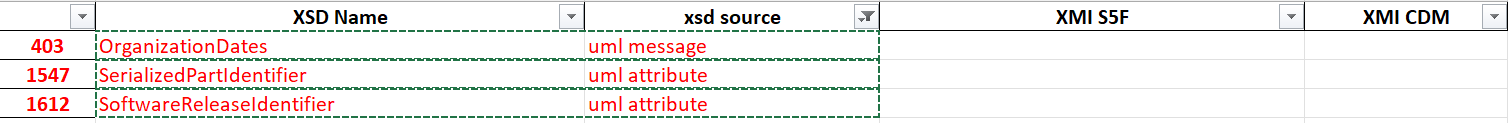

*71 Attributes are defined in both S5F or CDM files*<br>
*53 Classes are defined in both S5F and CDM files*<br><br>
If class or attribute is defined in both XMI file, its definition in S5F file overlaps definition in CDM XMI file: for instance PersonCompetence 



# CREATE S5000F XSD with data extracted from XMI

## root element

In [17]:
root_str ='''
<xsd:schema xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsig="http://www.w3.org/2000/09/xmldsig#" xmlns="http://www.asd-europe.org/s-series/s5000f" xmlns:vc="http://www.w3.org/2007/XMLSchema-versioning" xmlns:value="http://www.asd-europe.org/s-series/s5000f/validValues" xmlns:unit="http://www.asd-europe.org/s-series/s5000f/validValues" targetNamespace="http://www.asd-europe.org/s-series/s5000f" version="004-00" vc:minVersion="1.1">
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:import namespace="http://www.w3.org/2000/09/xmldsig#" schemaLocation="http://www.w3.org/TR/2008/REC-xmldsig-core-20080610/xmldsig-core-schema.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:annotation>
		<xsd:documentation>Specification: </xsd:documentation>
		<xsd:documentation>Issue number: 4.0</xsd:documentation>
		<xsd:documentation>Issue date: 2024-09-30</xsd:documentation>
		<xsd:documentation>Data model file: S5000F_4-0_Data_model_000-85.EAP</xsd:documentation>
		<xsd:documentation>XML schema release number: 004-00</xsd:documentation>
		<xsd:documentation>XML schema release date: 2024-09-30</xsd:documentation>
		<xsd:documentation>URL: http://www.s5000f.org</xsd:documentation>
		<xsd:documentation>Root element: isfDataset</xsd:documentation>
		<xsd:documentation>XSD generator version: DMEWG_GEN_2-0_002-43</xsd:documentation>
		<xsd:documentation>Copyright:
   Copyright (c) 2016-2024 by AeroSpace, Security and Defence Industries Association of Europe (ASD).
   
   Limitations of Liability:
   
   1. This material is provided 'As Is' and neither ASD nor any person who has contributed to the creation, revision or maintenance of
      the material makes any representations or warranties, express or implied, including but not limited to, warranties of
      merchantability or fitness for any particular purpose.
   2. Neither ASD nor any person who has contributed to the creation, revision or maintenance of this material shall be liable for any
      direct, indirect, special or consequential damages or any other liability arising from any use of this material.
   3. Revisions to this document may occur after its issuance. The user is responsible for determining if revisions to the material
      contained in this document have occurred and are applicable.
   
  </xsd:documentation>
	</xsd:annotation>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:import namespace="http://www.asd-europe.org/s-series/s5000f/validValues" schemaLocation="s5000f_4-0_valid_values.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:include schemaLocation="s5000f_4-0_project_specific_exchanges.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:element name="isfDataset" type="message"/>
 </xsd:schema>
 '''

In [18]:
root = etree.fromstring(root_str)

## Message

### UML \<\<Class\>\> classes 

<ol><li>A &lt;complexType&gt; is created in the UML class model XML schema.</li>
<li>This &lt;complexType&gt; is a child of the &lt;xsd:schema&gt; element.</li>
<li>This &lt;complexType&gt; has an attribute name which contains the UML class model. Its first letter is lowercase.</li></ol>

*Note: All UML class, interface and attribute names must be unique. So it is wise to check that there are no UML class name in the UML model.*

<ol><li>The &lt;complexType&gt; contains &lt;xsd:annotation&gt;&lt;xsd:documentation&gt; and &lt;xsd:appinfo&gt;&lt;source&gt;.</li>>>



a 16)
	The definition of the <complexType> must be an extension of either:
•	A <complexType> defined for the UML class in the uid patterns XML schema (refer to Para 8.5)
•	A <complexType> that represents a generalized UML class, if the UML class itself is a specialization of another UML class


In [19]:
s5f_class = s5f_class_attrib[s5f_class_attrib['stereotype'] .isin(['class', 'exchange'])]

s5f_class = pd.concat([
    s5f_class[s5f_class['xmlName'].str.startswith('uc')].sort_values(by='xmlName'),
    s5f_class[~s5f_class['xmlName'].str.startswith('uc')].sort_values(by='name')
])

s5f_class.head()

s5f_class.to_excel("s5f_class.xlsx")

In [20]:
# filter dataframe to keep only exchanges and classes
s5f_class = s5f_class_attrib[s5f_class_attrib['stereotype'] .isin(['class', 'exchange'])]

# order dataframe to align with xsd complexType order
s5f_class = pd.concat([
    s5f_class[s5f_class['xmlName'].str.startswith('uc')].sort_values(by='xmlName'),
    s5f_class[~s5f_class['xmlName'].str.startswith('uc')].sort_values(by='name')
])

# Adjust dataframe name, documentation and source to feed complexType element
s5f_class['Name'] = s5f_class['name'].astype(str).apply(lambda x: x[:1].lower() + x[1:] if x else x)
s5f_class['documentation'] = s5f_class['documentation'].astype(str).apply(lambda x: x.replace('<<', '[').replace('>>', ']'))
s5f_class['source'] = s5f_class['source'].astype(str).apply(lambda x: x.replace('_Data_model_75BR', ':'))+s5f_class['name']

# Patch to remove duplicate rows (like Infrastructure and MaintenanceFacility)
s5f_class = s5f_class.drop_duplicates(subset="Name", keep="first")

# Store in excel file to review the result
s5f_class.to_excel("Result.xlsx")

In [21]:
s5f_class.head()

,name,xmlName,documentation,identifier,stereotype,lower,upper,class,source,Name
995,InServiceDataFeedback,uc50000,InServiceDataFeedback is an [exchange] that re...,EAID_7DCA9B08_277E_4f57_82A6_E37206829643,exchange,NaN,NaN,NaN,S5000F:InServiceDataFeedback,inServiceDataFeedback
1001,MonitorEquipmentPerformance,uc50301,MonitorEquipmentPerformance is an [exchange] t...,EAID_2A4BBD19_F50F_42d6_9102_5293FAD785F9,exchange,NaN,NaN,NaN,S5000F:MonitorEquipmentPerformance,monitorEquipmentPerformance
996,InfluenceDesign,uc50302,InfluenceDesign is an [exchange] that represen...,EAID_7A18B51B_8139_4df1_94FC_786278895B85,exchange,NaN,NaN,NaN,S5000F:InfluenceDesign,influenceDesign
1067,ReportTrendsAndFailures,uc50303,ReportTrendsAndFailures is an [exchange] that ...,EAID_14E07D01_BD06_407b_B981_8C890E8D56A8,exchange,NaN,NaN,NaN,S5000F:ReportTrendsAndFailures,reportTrendsAndFailures
1030,ReportAvailability,uc50304,ReportAvailability is an [exchange] that repre...,EAID_BB0176F4_2AC8_4bc7_B6A7_1B044C2A25CC,exchange,NaN,NaN,NaN,S5000F:ReportAvailability,reportAvailability


In [22]:
df= s5f_class

In [23]:
# XML Namespace
XSD_NS = "http://www.w3.org/2001/XMLSchema"
XSD = "{%s}" % XSD_NS  # Namespace format for lxml

# Function to create XML for each row
def create_complex_type_xml(name, documentation, source):
    # Create comment starting line
    
    # Create complexType element
    complex_type = etree.Element(f"{XSD}complexType", attrib={"name": name}, nsmap={"xsd": XSD_NS})

    # Create and append annotation with documentation and source
    annotation = etree.SubElement(complex_type, f"{XSD}annotation")
    doc_element = etree.SubElement(annotation, f"{XSD}documentation")
    doc_element.text = documentation  # Set the documentation text

    appinfo = etree.SubElement(annotation, f"{XSD}appinfo")
    source_element = etree.SubElement(appinfo, "source")
    source_element.text = source  # Set the source text

    # Empty sequence
    etree.SubElement(complex_type, f"{XSD}sequence")

    # Add attributes to complexType
    uid_attr = etree.SubElement(complex_type, f"{XSD}attribute", name="uid", use="optional")
    simple_type = etree.SubElement(uid_attr, f"{XSD}simpleType")
    restriction = etree.SubElement(simple_type, f"{XSD}restriction", base=f"xsd:ID")
    etree.SubElement(restriction, f"{XSD}pattern", value="")    

    etree.SubElement(complex_type, f"{XSD}attribute", name="uri", type=f"xsd:anyURI", use="optional")
    etree.SubElement(complex_type, f"{XSD}attribute", name="crud", type="crudCode", default="I")

    return complex_type

# Create the root XML element <xsd:schema>
#root = etree.Element(f"{XSD}schema", nsmap={"xsd": XSD_NS})

# Iterate through each row and append its complexType to the root
for _, row in df.iterrows():
    # Insert a comment line before each complexType
    comment = etree.Comment('________________________________________________________________________________________________________________')
    root.append(comment)
    # Create and append the complexType
    complex_type_element = create_complex_type_xml(row["Name"], row["documentation"], row["source"])
    root.append(complex_type_element)





## Base Schema Definition

In [24]:
base_str = """<xsd:schema xmlns:xsd="http://www.w3.org/2001/XMLSchema">
<!-- ===================================== BASE SCHEMA DEFINITIONS ====================================== -->
	<xsd:simpleType name="uidRef">
		<xsd:restriction base="xsd:IDREF"/>
	</xsd:simpleType>
	<xsd:simpleType name="nonEmptyString">
		<xsd:restriction base="xsd:token">
			<xsd:minLength value="1"/>
		</xsd:restriction>
	</xsd:simpleType>
	<xsd:simpleType name="crudCode">
		<xsd:restriction base="xsd:string">
			<xsd:enumeration value="I">
				<xsd:annotation>
					<xsd:appinfo>
						<source>SX001G:insertedElement</source>
					</xsd:appinfo>
				</xsd:annotation>
			</xsd:enumeration>
			<xsd:enumeration value="D">
				<xsd:annotation>
					<xsd:appinfo>
						<source>SX001G:deletedElement</source>
					</xsd:appinfo>
				</xsd:annotation>
			</xsd:enumeration>
			<xsd:enumeration value="U">
				<xsd:annotation>
					<xsd:appinfo>
						<source>SX001G:updatedElement</source>
					</xsd:appinfo>
				</xsd:annotation>
			</xsd:enumeration>
			<xsd:enumeration value="R">
				<xsd:annotation>
					<xsd:appinfo>
						<source>SX001G:replacedElement</source>
					</xsd:appinfo>
				</xsd:annotation>
			</xsd:enumeration>
			<xsd:enumeration value="N">
				<xsd:annotation>
					<xsd:appinfo>
						<source>SX001G:nonChangedElement</source>
					</xsd:appinfo>
				</xsd:annotation>
			</xsd:enumeration>
		</xsd:restriction>
	</xsd:simpleType>
</xsd:schema>
 """

In [25]:
base = etree.fromstring(base_str)
root.append(base)

In [26]:
# Convert the full XML tree to a string
full_xml = etree.tostring(root, pretty_print=True, encoding="unicode")

# Display the final XML
print(full_xml)

<xsd:schema xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsig="http://www.w3.org/2000/09/xmldsig#" xmlns="http://www.asd-europe.org/s-series/s5000f" xmlns:vc="http://www.w3.org/2007/XMLSchema-versioning" xmlns:value="http://www.asd-europe.org/s-series/s5000f/validValues" xmlns:unit="http://www.asd-europe.org/s-series/s5000f/validValues" targetNamespace="http://www.asd-europe.org/s-series/s5000f" version="004-00" vc:minVersion="1.1">
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:import namespace="http://www.w3.org/2000/09/xmldsig#" schemaLocation="http://www.w3.org/TR/2008/REC-xmldsig-core-20080610/xmldsig-core-schema.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:annotation>
		<xsd:documentation>Specification: </xsd:documentation>
		<xsd:documentation>Issue number: 4.0</xsd:documentation>
		<xsd:documentation>I

### Documentation: mapping between dataframe and XSD-path

#### Classes in XMI dataframe to XSD

In [27]:
# get number of classes to be processed
s5f_class = s5f_class_attrib[s5f_class_attrib['stereotype'] == 'class']
count = s5f_class.groupby(['source']).size()
print(f"There are \033[1m{count.iloc[0]} classes\033[0m in \033[1m{count.index[0]}\n\n\033[0m.")
s5f_class.head()

There are 168 classes in S5000F_Data_model_75BR

.


,name,xmlName,documentation,identifier,stereotype,lower,upper,class,source
0,TechnicalOrder,to,TechnicalOrder is a WorkItem raised by Mainten...,EAID_254534EB_5372_4bfd_9577_6CB629060F89,class,NaN,NaN,NaN,S5000F_Data_model_75BR
3,ServiceBulletin,servBu,ServiceBulletin is a class representing a set ...,EAID_820B91E7_C617_4565_B8EE_4DF14992D503,class,NaN,NaN,NaN,S5000F_Data_model_75BR
9,DownTimePeriod,dwnTP,DownTimePeriod is a class representing a plann...,EAID_11AAC606_5331_41d2_927D_A1B9031FAC61,class,NaN,NaN,NaN,S5000F_Data_model_75BR
14,PlannedUpgradeTimescales,plut,PlannedUpgradeTimescales is a class that defin...,EAID_885CB3DE_72C1_4feb_AC39_D28334811797,class,NaN,NaN,NaN,S5000F_Data_model_75BR
20,PlannedItemUpgrade,pliu,PlannedItemUpgrade is a <<class>> that defines...,EAID_82C9C43C_8E27_4c87_AE94_29E949B1C56C,class,NaN,NaN,NaN,S5000F_Data_model_75BR


**Filter XMI dataframe with dataframe['stereotype'] == 'class'**

| Name | XSD Path                        | Dataframe   | Remark |
|-------|------------------------------------|---------------|----------|
| name  | /xsd:schema/xsd:complexType/@name | s5f_class_attrib['name'] | The initial uppercase letter should be converted to lowercase |
| documentation   | /xsd:schema/xsd:complexType/xsd:annotation/xsd:documentation | s5f_class_attrib['documentation'] | replace '<<' by '['  and '>>' by ']' |
| source    | /xsd:schema/xsd:complexType/xsd:annotation/xsd:appinfo/source   | s5f_class_attrib['source'] | if S5000F_Data_model_75BR: "S5000F:name"              if SX002D_Data_model: "SX001G:name" |

#### Attributes in XMI dataframe to XSD

In [28]:
# get number of atttributes to be processed
s5f_attribute = s5f_class_attrib[s5f_class_attrib['stereotype'] == 'characteristic']
count = s5f_attribute.groupby(['source']).size()
print(f"There are \033[1m{count.iloc[0]} classes\033[0m in \033[1m{count.index[0]}\n\n\033[0m.")
s5f_attribute.head()

There are 571 classes in S5000F_Data_model_75BR

.


,name,xmlName,documentation,identifier,stereotype,lower,upper,class,source
1,technicalOrderPriority,toPri,technicalOrderPriority is a classification tha...,EAID_326F0402_9153_427c_8B4A_34DF6D4949FB,characteristic,1,1,TechnicalOrder,S5000F_Data_model_75BR
2,technicalOrderRequiredImplementationDate,implDate,technicalOrderRequiredImplementationDate is th...,EAID_AC91BE7E_AF01_40b4_9A9D_50981B4915B0,characteristic,0,1,TechnicalOrder,S5000F_Data_model_75BR
4,serviceBulletinType,sbType,serviceBulletinType is classification that all...,EAID_1163BE3D_8CD8_44e5_A326_7243B777FFE4,characteristic,1,1,ServiceBulletin,S5000F_Data_model_75BR
5,serviceBulletinPriority,priority,serviceBulletinPriority is a classification th...,EAID_0A77D97C_5556_40f5_95DE_B77D1064DFE7,characteristic,1,1,ServiceBulletin,S5000F_Data_model_75BR
6,serviceBulletinEmbodimentLimit,limit,serviceBulletinEmbodimentLimit is a Date by wh...,EAID_52BDEB3E_564E_4cd9_9EC4_8710A661BD64,characteristic,0,1,ServiceBulletin,S5000F_Data_model_75BR


# TO BE REVIEWED

### Collect XMI data

In [29]:
def xmi_classes(*files):
    """
    Function which collects following information about classes and attributes from XMI files downloaded from Enterprise Architect:
        name              /xmi:XMI/*//element[@xmi:type='uml:Class']/@name
        identifier        /xmi:XMI/*//element[@xmi:type='uml:Class']/@xmi:idref
        documentation     /xmi:XMI/*//element[@xmi:type='uml:Class']/properties/@documentation
        xmlname           /xmi:XMI/*//element[@xmi:type='uml:Class']/tags/tag[@name='xmlName']/@value
        stereotype        /xmi:XMI/*//element[@xmi:type='uml:Class']/properties/@stereotype
        isabstract        /xmi:XMI/*//element[@xmi:type='uml:Class']/properties/@isAbstract
        
    Input:         list of XMI file to be analyzed
    Output:        Dataframe df(name, identifier, xmlname, stereotype, isAbstract, documentation, source)
    """
    if not files:
        raise ValueError("At least one file must be provided.")
    
    rows = []
    for file in files:
        source = Path(file.name).stem
        ns = get_namespaces(file)  # Ensure get_namespaces is implemented correctly
        xmi = '{' + ns['xmi'] + '}'

        context = etree.iterparse(file, events=('end',), tag=('element',))
        type = xmi + 'type'


        for event, elem in context:                               # Iterate over element closing tags
            if elem.attrib.get(type) == 'uml:Class':
                # collect classes information
                name = elem.attrib.get('name')
                identifier = elem.attrib.get(f'{xmi}idref')

                for e in elem.xpath('./properties'):
                    documentation = e.get('documentation')
                    stereotype = e.get('stereotype')
                    isabstract = e.get('isAbstract')

                xmlNames = elem.xpath("./tags/tag[@name='xmlName']/@value",namespaces = ns)
                xmlname = xmlNames[0] if xmlNames else ''

                rows.append({'Name': name, 'xmlName': xmlname, 'Identifier': identifier, 'Stereotype': stereotype, 
                             'IsAbstract': isabstract,'Documentation': documentation,'source':source})
                elem.clear()

        df = pd.DataFrame(rows,columns=['Name','xmlName','Stereotype','IsAbstract','Identifier','source', 'Documentation'])
    return df

In [30]:
#xmi_classes = xmi_classes(s5f,cdm)
xmi_classes = xmi_classes(s5f)

In [31]:
xmi_classes.head()

,Name,xmlName,Stereotype,IsAbstract,Identifier,source,Documentation
0,TechnicalOrder,to,class,false,EAID_254534EB_5372_4bfd_9577_6CB629060F89,S5000F_Data_model_75BR,TechnicalOrder is a WorkItem raised by Mainten...
1,ServiceBulletin,servBu,class,false,EAID_820B91E7_C617_4565_B8EE_4DF14992D503,S5000F_Data_model_75BR,ServiceBulletin is a class representing a set ...
2,PlannedPartInstallationLocation,plpil,relationship,false,EAID_2B2550AE_D774_4abb_8B1D_1FD62BFD0683,S5000F_Data_model_75BR,PlannedPartInstallationLocation is a <<relatio...
3,DownTimePeriod,dwnTP,class,false,EAID_11AAC606_5331_41d2_927D_A1B9031FAC61,S5000F_Data_model_75BR,DownTimePeriod is a class representing a plann...
4,PlannedUpgradeTimescales,plut,class,false,EAID_885CB3DE_72C1_4feb_AC39_D28334811797,S5000F_Data_model_75BR,PlannedUpgradeTimescales is a class that defin...


### Get XSD S5000F data

In [32]:
def xsd_complexType(xml_file, start_comment, end_comment):
    """
    Extracts the first-level children <complexType> of the root element between specific comments 
    in an XML file and returns their 'name' attributes in a DataFrame.
    
    Parameters:
        xml_file (str):      Path to the XML file.
        start_comment (str): Text of the starting comment.
        end_comment (str):   Text of the ending comment.
    
    Returns:
        df (pd.DataFrame):    A DataFrame containing the 'name' attributes of the matching elements.
    """
    # Parse the XML file and get the root
    tree = etree.parse(xml_file)
    root = tree.getroot()

    # Get xsd namespace prefix from the root
    xsd_ns = root.nsmap.get("xsd", "http://www.w3.org/2001/XMLSchema")

    # Variables to track parsing state
    inside_section = False
    first_level_children = []

    context = etree.iterparse(xml_file, events=("end", "comment"), tag=[f"{{{xsd_ns}}}complexType"])
    for event, elem in context:
        if event == "comment":                                           # Check for the start or end comment
            if elem.text.strip() == start_comment:        
                inside_section = True
            elif elem.text.strip() == end_comment:
                inside_section = False

        elif event == "end" and inside_section:                          # triggered on closing element complexType
            if elem.getparent().tag == root.tag:                         # check that current element is a direct child of root
                first_level_children.append(elem.attrib.get('name'))
                elem.clear()                                             # Clear to save memory for large files

    # Create and return a DataFrame
    df = pd.DataFrame(first_level_children, columns=['class_name'])
    return df

In [33]:
# 1 - Collect first level complexType between UML MESSAGE and UML ATTRIBUTES.
start_comment = '========================================== UML MESSAGE ============================================'
end_comment = '========================================== UML ATTRIBUTES =========================================='
xsd_classes = xsd_complexType(isfDataset, start_comment, end_comment)

# 2 - Set first letter of name as capital letter
xsd_classes['class_name'] = xsd_classes['class_name'].str[0].str.upper()+xsd_classes['class_name'].str[1:]

# 3 - Rename column 'class_name' to 'Name' for preparing comparaison
xsd_classes = xsd_classes.rename(columns={'class_name':'Name'})

# 4 - Sort Name by alphabetical order
xsd_classes.sort_values(by=['Name'],inplace=True)

# 4 - Display result
print(f"\033[1mThere are {len(xsd_classes)} classes in XSD - UML MESSAGE.\033[0m")
xsd_classes.head()

There are 619 classes in XSD - UML MESSAGE.


,Name
106,Accelerometer
107,Action
108,AggregatedElement
109,AggregatedElementRevision
110,AllocatedTaskLocation


### Compare XMI vs XSD

In [34]:
# Store result in an excel file
with pd.ExcelWriter("output.xlsx") as writer:
    xmi_classes.to_excel(writer, sheet_name="XMI Classes", index=False)
    xsd_classes.to_excel(writer, sheet_name="XSD Classes", index=False)

## Store XSD information

In [35]:
with pd.ExcelWriter("XSD_complexType.xlsx") as writer:
    uml_message_df.to_excel(writer, sheet_name="Messages", index=False)
    uml_attributes_df.to_excel(writer, sheet_name="Attributes", index=False)
    uml_attribute_group_df.to_excel(writer, sheet_name="Attribute Groups", index=False)
    uml_class_reference_df.to_excel(writer, sheet_name="Class Reference", index=False)
    uml_select_interface_df.to_excel(writer, sheet_name="Select Interface", index=False)
    uml_extend_interface_df.to_excel(writer, sheet_name="Extend Interface", index=False)
    

NameError: name 'uml_message_df' is not defined

### Collect XMI data

In [ ]:
def elements(*files):
    """
    In xmi file:
      <thecustomprofile:xmlName base_Class="EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A" xmlName="toemb"/>
      <UML_Profile_003-00:relationship base_Class="EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A"/>
	  <thecustomprofile:uidPattern base_Class="EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A" uidPattern="toemb"/>

      <element xmi:idref="EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A" xmi:type="uml:Class" name="TechnicalOrderEmbodied" scope="public">

    collect
        identifier:    /xmi:XMI/uml:Model/UML_Profile_003-00:relationship/@base_Class[0]
        name:          /xmi:XMI/xmi:Extension/elements/element[@xmi:idref='EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A']/@name
        xml_name:      /xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Class='EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A']/@xmlName
        uid_pattern:   /xmi:XMI/uml:Model/thecustomprofile:uidPattern[@base_Class='EAID_DC7CEC70_4710_41d9_B77E_55BD4AEFEB3A']/@uidPattern

    Input:         list of XMI file to be analyzed
    Output:        dataframe (identifier, name, xml_name, uid_pattern)
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:            
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)
        source = Path(file.name).stem

        ids = tree.xpath("/xmi:XMI/uml:Model/thecustomprofile:uidPattern/@base_Class", namespaces=ns)
        for id in ids:
            name = root.xpath(f"/xmi:XMI/xmi:Extension/elements/element[@xmi:idref='{id}'][@xmi:type='uml:Class']/@name",namespaces=ns)[0]
            uid_pattern = root.xpath(f"/xmi:XMI/uml:Model/thecustomprofile:uidPattern[@base_Class='{id}']/@uidPattern",namespaces=ns)[0]
            xml_name = root.xpath(f"/xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Class='{id}']/@xmlName",namespaces=ns)[0]
            rows.append({'Identifier':id,'Name': name, 'xmlName': xml_name,'uidPattern': uid_pattern,'source':source})
        
        df = pd.DataFrame(rows,columns=['Identifier','Name','xmlName','uidPattern','source'])
        df.sort_values(by=["Name"],inplace=True)
  
    return df

In [ ]:
xmi_class_references = elements(s5f,cdm)
xmi_class_references.to_excel("xmi_class_references.xlsx")

# Display result
print(f"\033[1mxmi_class_references: {len(xmi_class_references)} rows 'UML CLASS REFERENCE UTILITY CLASSES' extracted from XMI (s5f,cdm).\033[0m")
#print(list(xmi_class_references['Name']))

### Gathers information of classes occuring in both XMI files

In [ ]:
df = elements(s5f,cdm)

# Identify names that appear two times
duplicate_names = df["Name"].value_counts()
duplicate_names = duplicate_names[duplicate_names == 2].index  # Keep only duplicates

# Separate duplicates and non-duplicates
df_duplicates = df[df["Name"].isin(duplicate_names)]
df_unique = df[~df["Name"].isin(duplicate_names)]

# Merge duplicates by concatenating values
df_merged = df_duplicates.groupby("Name", as_index=False).agg({
    "Identifier": ", ".join,  
    "uidPattern": ", ".join,
    "source": ", ".join,
    "xmlName": ", ".join
})

# Combine merged duplicates with unique rows
xmi_class_references = pd.concat([df_unique, df_merged], ignore_index=True)

# Display result
print(f"\033[1mThere are {len(xmi_class_references)} unique classes REFERENCE UTILITY CLASSES identified in XMI files.\033[0m")
print(f"\033[1mAmong them {len(df_merged)} unique classes REFERENCE UTILITY CLASSES occurs in both XMI files:\033[0m")
#print(list(df_final['Name']))

# Store result in Excel file
xmi_class_references.to_excel("xmi_class_references.xlsx")

### Compare XSD versus XMI data

*Identify <b>50 classes</b> in xsd_class_references['class_name'] and not in xmi_class_references['Name']* 

In [ ]:
df_xsd.head()

In [ ]:
# Prepare xsd file to be compare with xmi file
df_xsd = xsd_class_references
df_xsd = xsd_class_references.rename(columns={'class_name':'Name'})     # rename column class_name
df_xsd['Name'] = df_xsd['Name'].str[:-3]                                # remove 'Ref' from name 

xmi_not_xsd, xsd_not_xmi  = dataframe_compare(xmi_class_references, 
                                              df_xsd, 
                                              column_name="Name", 
                                              df1_name="XMI", 
                                              df2_name="XSD")

In [ ]:
# 1 - Collect first level complexType between UML MESSAGE and UML ATTRIBUTES.
start_comment = '======================== UML <<EXTEND>> INTERFACE REFERENCE UTILITY CLASSES ========================'
end_comment = '============================== UML SPECIALIZATION UTILITY CLASSES =================================='
uml_extend_interface_df = xsd_complexType(isfDataset, start_comment, end_comment)

# 2 - Remove duplicate classes name (if any)
duplicates = uml_extend_interface_df[uml_extend_interface_df.duplicated(subset='class_name', keep='first')]
duplicated_name = list(duplicates['class_name'])
uml_extend_interface_df.drop_duplicates(subset='class_name',inplace=True)

# 3 - Set first letter of name as capital letter
uml_extend_interface_df['class_name'] = uml_extend_interface_df['class_name'].str[0].str.upper()+uml_extend_interface_df['class_name'].str[1:]

# 4 - Display result
print(f"Duplicated classes are: {duplicated_name}. ")
print(f"After removing these {len(duplicates)} duplicated class(es) there are {len(uml_extend_interface_df)} classes in XSD - UML MESSAGE.")
uml_extend_interface_df.head()

## 'XSD UML Message' vs 's5000F XMI'

1 - check that all **XSD complexType** identifed as UML Message have an XMI class localized in **s5000F XMI** by xpath /xmi:XMI/uml:Model/.//packagedElement[@xmi:type='uml:Class']/@name<br>
2 - check that all name **s5000F XMI** located at xpath /xmi:XMI/uml:Model/.//packagedElement[@xmi:type='uml:Class']/@name have an **XSD complexType** identifed as UML Message

In [ ]:
# Save result in excel file working.xlsx
with pd.ExcelWriter("Working.xlsx", engine="openpyxl") as writer:
    xsd_message.to_excel(writer, sheet_name="xsd", index=False)
    s5f_class_attrib.to_excel(writer, sheet_name="s5f xmi", index=False)



def count_classes_attributes(df):
    # Count class occurrences per source
    class_count = df[df['class'].isna()].groupby('source').size().reset_index(name='class_count')
    
    # Count attribute occurrences per source
    attribute_count = df[df['class'].notna()].groupby('source').size().reset_index(name='attribute_count')
    
    # Merge both counts
    result = class_count.merge(attribute_count, on='source', how='outer').fillna(0)
    
    # Convert counts to integers
    result[['class_count', 'attribute_count']] = result[['class_count', 'attribute_count']].astype(int)

    # Compute total occurrences
    total_row = pd.DataFrame({'source': ['Total'], 
                              'class_count': [result['class_count'].sum()], 
                              'attribute_count': [result['attribute_count'].sum()]})
    
    # Find common class names (names where class is NaN and appear in multiple sources)
    common_class_names = df[df['class'].isna()].groupby('name')['source'].nunique()
    common_class_list = common_class_names[common_class_names > 1].index.tolist()  # List of common class names
    common_class_count = len(common_class_list)

    # Find common attribute names (names where class is NOT NaN and appear in multiple sources)
    common_attribute_names = df[df['class'].notna()].groupby('name')['source'].nunique()
    common_attribute_list = common_attribute_names[common_attribute_names > 1 ].index.tolist()  # List of common attribute names
    common_attribute_count = len(common_attribute_list)

    # Add common source row
    common_row = pd.DataFrame({'source': ['Common Source'], 
                               'class_count': [common_class_count], 
                               'attribute_count': [common_attribute_count]})

    # Append common source & total rows
    result = pd.concat([result, common_row, total_row], ignore_index=True)

    # Return the result and the lists of common names
    return result, common_class_list, common_attribute_list

# Call function
result, common_class_names, common_attribute_names = count_classes_attributes(all_class_attrib)
result.head()

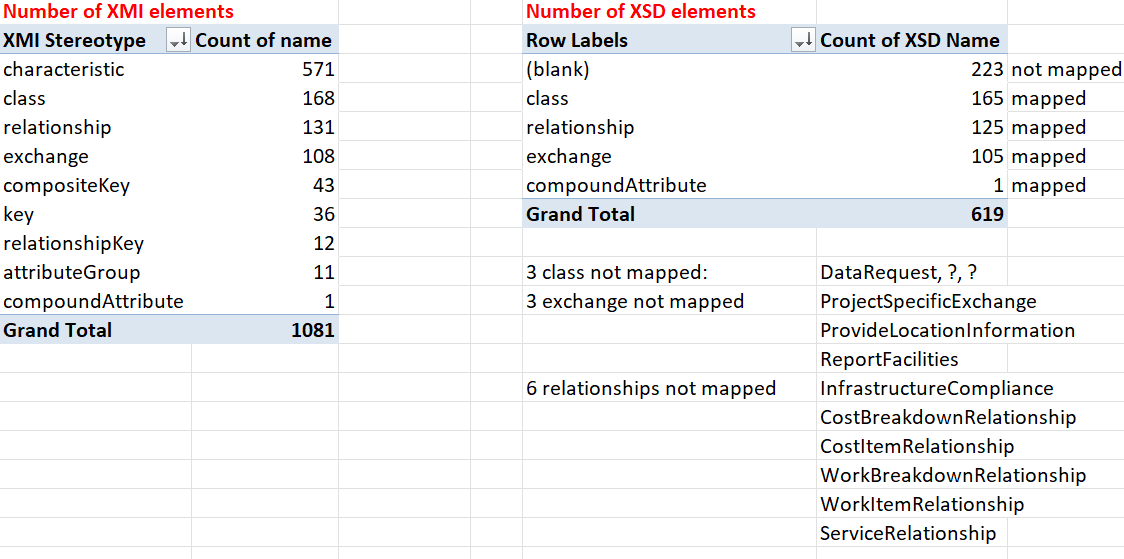

**XSD UML MESSAGE** list **619 complexType** which are mapped onto **396 XMI S5000F**:<br>
whose stereotype are:<ul><li>*165 class*, <li>*125 relationship*, <li>*105 exchnage*, <li>*1 compoundAttribute*


In [ ]:
s5f_class_attrib.head()

### XMI UML message
Collect **class_xmlName** located at &emsp;**/xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Class]/@xmlName**<br>
then use class_xmlName to collect **class_identifier** located at&emsp;
**xmi:XMI/uml:Model/thecustomprofile:xmlName[@xmlName='xmlname']/@base_Class**<br>
and then use class_identifier to collect **class_name** located at&emsp;
**/xmi:XMI/xmi:Extension/elements/element[@xmi:idref='class_identifier']/@name**

In [ ]:
def uml_message_elts(*files):
    """
    Get a set of element names which contains the string path
    Input:         list of XMI file to be analyzed
    Output:        set of elements
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:            
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)
        source = Path(file.name).stem

        elements = tree.xpath("/xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Class]/@xmlName", namespaces=ns)
        for xmlname in elements:
            id = tree.xpath(f"/xmi:XMI/uml:Model/thecustomprofile:xmlName[@xmlName='{xmlname}']/@base_Class", namespaces=ns)[0]
            name = tree.xpath(f"/xmi:XMI/xmi:Extension/elements/element[@xmi:idref='{id}']/@name", namespaces=ns)[0]
            
            rows.append({'Identifier':id,'Name': name, 'xmlName': xmlname,'source':source})
        
        df = pd.DataFrame(rows,columns=['Identifier','Name','xmlName','source'])
        # df = df.sort_values(by=["Name","source"])
    return df

In [ ]:
xmi_all = uml_message_elts(s5f,cdm)
nb_s5f = xmi_all.groupby(['source']).size()
common = 

print(nb_s5f)
print(f"\033[1mThere are {len(xmi_all)} classes in XMI - UML MESSAGE.\033[0m")
xmi_uml_message.head()

In [ ]:
# get XMI S5000F message elements
xmi_s5f = uml_message_elts(s5f)

In [ ]:
# Filter rows where Name is 'Message'
message_row = xmi_s5f[xmi_s5f['Name'] == 'Message']

# Filter rows where xmlName starts with 'uc' and sort them
uc_rows = xmi_s5f[xmi_s5f['xmlName'].str.startswith('uc', na=False)].sort_values(by='xmlName')

# Filter remaining rows and sort them by Name
other_rows = xmi_s5f[~xmi_s5f['xmlName'].str.startswith('uc', na=False) & (xmi_s5f['Name'] != 'Message')].sort_values(by='Name')

# Concatenate the results
xmi_s5f_ordered = pd.concat([message_row, uc_rows, other_rows], ignore_index=True)

# Store result and give an overview
xmi_s5f_ordered.to_excel("xmi_ordered.xlsx")
print(xmi_s5f_ordered.shape)
xmi_s5f_ordered.head()

### Compare XMI and XSD UML message

In [ ]:
# Drop duplicates, keeping the last occurrence which has source SX002D_Data_model
df_unique = xmi_uml_message.drop_duplicates(subset="Name", keep="last")
df_unique = df_unique.reset_index(drop=True)
#df_unique.head()

df1,df2 = dataframe_compare(df_unique, 
                            xsd_uml_message, 
                            column_name="Name",
                            df1_name="xmi_uml_message",
                            df2_name="xsd_uml_message")

Located at `/xmi:XMI/xmi:Extension/primitivetypes/*//packagedElement[@xmi:type='uml:PrimitiveType']/@name`, we have the 12 missing names:

- ClassificationType
- DateTime
- TypeData
- TypeDescription
- IdentifierType
- SingleValuePropertyType
- PropertyType
- TimeType
- umlBoolean
- umlInteger
- ValueRangePropertyType
- ValueWithTolerance

**Five missing values**:
- DateTimeType
- OrganizationDates
- TextPropertyType
- UmlReal
- UmlString

**Five additional values**:
- DatedClassification
- DateRange
- Dimensions
- PropertyType
- ThreeDimensionalPropertyType


#### Compare only xmi S5000F (not xmi SX002G) versus xsd

In [ ]:
xmi_s5f_uml_message = uml_message_elts(s5f)

df3,df4 = dataframe_compare(xmi_s5f_uml_message, 
                            xsd_uml_message, 
                            column_name="Name",
                            df1_name="xmi_s5f_uml_message",
                            df2_name="xsd_uml_message")

## Attributes in XMI file

In [ ]:
def uml_attribute_elts(*files):
    """
    Get a set of element names which contains the string path
    Input:         list of XMI file to be analyzed
    Output:        set of elements
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:            
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)
        source = Path(file.name).stem

        elements = tree.xpath("/xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Property]/@xmlName", namespaces=ns)

        for att_xmlname in elements:
            print(att_xmlname)
            att_identifier = tree.xpath(f"xmi:XMI/uml:Model/thecustomprofile:xmlName[@xmlName='{att_xmlname}']/@base_Property", namespaces=ns)[0]
            print(att_identifier)
            name = tree.xpath(f"/xmi:XMI/xmi:Extension/elements/element/attributes/attribute[@xmi:idref='{att_identifier}']/@name", namespaces=ns)[0]
            print(name)
            rows.append({'Identifier':att_identifier,'Name': name, 'xmlName': att_xmlname,'source':source})
        
        df = pd.DataFrame(rows,columns=['Identifier','Name','xmlName','source'])
        df = df.sort_values(by=["Name","source"])
    return df

In [ ]:
def analyse_df(df,field):
    class_count = df[df['class'].isna()].groupby(field).size().reset_index(name='class_count')

In [ ]:
df = uml_attribute_elts(s5f,cdm)
print(len(df))
df.head()


## Attribute Groups in XMI file

In [ ]:
# function to collect information about attribute groups in XMI file
def elements(*files):
    """
    Get a set of element names which contains the string path
    Input:         list of XMI file to be analyzed
    Output:        set of elements
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:            
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)
        source = Path(file.name).stem

        elements = tree.xpath("/xmi:XMI/uml:Model/*", namespaces=ns)
        # Filter elements having 'attributeGroup' in its tag and then get its attributes base_Class
        ids = [el.get("base_Class") for el in elements if "attributeGroup" in el.tag]

        for id in ids:
            name = root.xpath(f"/xmi:XMI/xmi:Extension/elements/element[@xmi:idref='{id}'][@xmi:type='uml:Class']/@name",namespaces=ns)[0]
            xmlname = root.xpath(f"/xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Class='{id}']/@xmlName",namespaces=ns)[0]
            rows.append({'Identifier':id,'Name': name, 'xmlName': xmlname,'source':source})
        
        df = pd.DataFrame(rows,columns=['Identifier','Name','xmlName','source'])
        df.sort_values(by=["Name"],inplace=True)
  
    return df

In [ ]:
# collect information about attribute groups in XMI files
xmi_attribute_groups = elements(s5f,cdm)
xmi_attribute_groups.to_excel("xmi_attribute_groups.xlsx")

# Display result
print(f"\033[1m There are {len(xmi_attribute_groups)} ATTRIBUTE GROUPS classes in XMI s5f and XMI cdm:\033[0m")
#print(list(xmi_attribute_groups['Name']))

In [ ]:
# Compare collected information in XMI with XSD information
xsd_attribute_groups.rename(columns={'class_name':'Name'},inplace=True)
xmi_not_xsd, xsd_not_xmi  = dataframe_compare(xmi_attribute_groups, 
                                              xsd_attribute_groups, 
                                              column_name="Name", 
                                              df1_name="XMI", 
                                              df2_name="XSD")

*4 classes of XMI "SX002D_Data_model" are not in XSD:<ul><li> AdditionalTrainingNeed,<li> MeasuringPointDegradedStateDefinition, <li>MeasuringPointFaultStateDefinition,<li>TimeOffset*

**CONCLUSION:<br>Attribute groups which are in XSD are the one called by UML MESSAGE complexType**

# Compare XSD complexType versus XMI classes and attributes

In [ ]:
xsd_complexType = xsd_complexType.merge(df_s5f, on='class_name', how='left').rename(columns={'source': 'source 1'})
xsd_complexType = xsd_complexType.merge(df_cdm, on='class_name', how='left').rename(columns={'source': 'source 2'})

# Identify XSD complexType not existing in XMI UML classes
missing_source = (xsd_complexType['source 1'].isna() & xsd_complexType['source 2'].isna())

# Filter the DataFrame to get rows where both sources are missing
missing_classes = xsd_complexType.loc[missing_source, 'class_name']

# Print the missing class names
print(f"List of elements located as \033[31mxsd:complexType\033[0m in XSD which are not in XMI files\n {list(missing_classes)}")

In [ ]:
with pd.ExcelWriter('Results/Classes.xlsx',engine='xlsxwriter') as writer:
    df_s5f.to_excel(writer, sheet_name='S5000F', index=False)
    df_cdm.to_excel(writer, sheet_name='SX002G', index=False)
    xsd_complexType.to_excel(writer, sheet_name='XSD UML Message', index=False)

In XMI files, UML attribute information is located at **/xmi:XMI/*//element\[@xmi:type='uml:Class' and @name='className']/attributes/attribute/**.

### Collect attribute from XMI S5000F

In [ ]:
df_s5f = get_attributes(s5f)
class_count = df_s5f['class_name'].nunique()

missing_xmlName = df_s5f[df_s5f['att_xmlname'] == 'MISSING']

print(f"There are \033[31m{len(df_s5f)} attributes\033[30m owned by {class_count} classes in S5000F XMI file.")
print(f"Following classes {list(missing_xmlName['class_name'])}\n have attribute without taggedValues xmlName !")

In [ ]:
df_s5f['key'] = df_s5f['class_name']+'_'+df_s5f['att_name']
df_s5f['att_id']=df_s5f.index
df_s5f.index=df_s5f['key']
df_s5f.drop(columns=['key'],inplace=True)

# identify duplicate index
duplicates = df_s5f.index[df_s5f.index.duplicated()]
print(f"Some rows have identical 'class name - attribute name':\n {list(duplicates)}.")

# remove duplicates by keeping only the first occurence
df_s5f = df_s5f[~df_s5f.index.duplicated(keep='first')]

### Collect attributes from XMI SX002G

In [ ]:
df_cdm = get_attributes(cdm)
class_count = df_cdm['class_name'].nunique()
missing_xmlName = df_cdm[df_cdm['att_xmlname'] == 'MISSING']
print(f"There are \033[31m{len(df_cdm)} attributes\033[30m owned by {class_count} classes in SX002G XMI file.")
print(f"Following classes {list(missing_xmlName['class_name'])}\n have attribute without taggedValues xmlName !")

In [ ]:
df_cdm['key'] = df_cdm['class_name']+'_'+df_cdm['att_name']
df_cdm['att_id']=df_cdm.index
df_cdm.index=df_cdm['key']
df_cdm.drop(columns=['key'],inplace=True)

# identify duplicate index
duplicates = df_cdm.index[df_cdm.index.duplicated()]
print(f"Some rows have identical 'class name - attribute name':\n {list(duplicates)}.")
# remove duplicates by keeping only the first occurence
df_cdm = df_cdm[~df_cdm.index.duplicated(keep='first')]

In [ ]:
df_all = get_attributes(cdm,s5f)
class_count = df_all['class_name'].nunique()
missing_xmlName = df_all[df_all['att_xmlname'] == 'MISSING']
print(f"There are \033[31m{len(df_all)} attributes\033[30m owned by {class_count} classes in S5000F and SX002G XMI files.")
print(f"Following classes {list(missing_xmlName['class_name'])}\n have attribute without taggedValues xmlName !")

In [ ]:
df_all.head()

In [ ]:
grouped_df = df.groupby(['att_type']).size().reset_index(name='count')  # group by attribute type
attributeType = grouped_df.sort_values(by='count', ascending=False)         # Sort by the 'count' column in descending order
print(f"Grouped by att_type: {attributeType}")

In [ ]:
# ANALYSIS of IdentifierType
df1 = df[df['att_type'] == 'IdentifierType']          # Filter the DataFrame based on 'att_type'

# Group by 'att_low' and 'att_up', and aggregate the count and the list of 'name' values
df2 = df1.groupby(['att_low', 'att_up']).agg(
    count=('att_name', 'size'),                       # Count the number of occurrences
    names=('att_name', lambda x: list(x))             # Collect the 'name' values into a list
).reset_index()

df2.head()

# If necessary print column names using:
# list(df2['names'].iloc(0))[0]

In [ ]:
# ANALYSIS of ClassificationType
df1 = df[df['att_type'] == 'ClassificationType']          # Filter the DataFrame based on 'att_type'

# Group by 'att_low' and 'att_up', and aggregate the count and the list of 'name' values
df2 = df1.groupby(['att_low', 'att_up']).agg(
    count=('att_name', 'size'),                       # Count the number of occurrences
    names=('att_name', lambda x: list(x))             # Collect the 'name' values into a list
).reset_index()

df2.head()

# Print the content of the first row in the 'names' column: print(df2['names'].iloc[0])
#print(df2['names'].iloc[0])

In [ ]:
# ANALYSIS based on Attribute Type, lower and upper values 
# Group by 'att_low' and 'att_up', and aggregate the count and the list of 'name' values
df2 = df.groupby(['att_type','att_low', 'att_up']).agg(
    count=('att_name', 'size'),            # Count the number of occurrences
    names=('att_name', lambda x: list(x))             # Collect the 'name' values into a list
).reset_index().sort_values(by='count', ascending=False)

df2.head(40)

In [ ]:
### TO BE DEBUGGED

from lxml import etree
import pandas as pd

def find_xsd_element(row):
    class_name = row['class_name']
    class_name = class_name[0].lower() + class_name[1:]  # Downcase first letter
    attr_xmlname = row['att_xmlname']
    
    # XPath to find the element
    xpath_expr = f"/xsd:schema/xsd:complexType[@name='{class_name}']/*/xsd:element[@name='{attr_xmlname}']"
    
    # Define namespace mapping for XSD
    ns = {'xsd': 'http://www.w3.org/2001/XMLSchema'}
    tree = etree.parse(isfDataset)  # isfDataset should be defined
    root = tree.getroot()
    
    matches = root.xpath(xpath_expr, namespaces=ns)

    attributes_dict = {}  # Default empty dictionary
    converted_xml = ''  # Default empty XML string

    if matches:
        xml_data = etree.tostring(matches[0], pretty_print=True, encoding='unicode')

        element = etree.fromstring(xml_data)
        local_name = etree.QName(element).localname  # Get local name
        new_element = etree.Element(local_name)  # Create a new element with the local name

        # Extract attributes
        attributes_dict = {name: value for name, value in element.attrib.items()}
        
        # Copy attributes to new element
        for name, value in attributes_dict.items():
            new_element.set(name, value)

        # Convert to XML string
        converted_xml = etree.tostring(new_element, pretty_print=True).decode()
    
    # Return dictionary containing attributes and XML element
    return {**attributes_dict, 'element': converted_xml}

# Apply function and expand dictionary into separate columns
df_all = df_all.join(df_all.apply(find_xsd_element, axis=1).apply(pd.Series))

# Print resulting DataFrame
df_all.head()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8, 6))
df_all['colA']= df_all['att_type'].astype(str)
df_all['colB']= df_all['nillable'].astype(str)
plt.scatter(df_all['colA'], df_all['colB'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('att_type')
plt.ylabel('nillable')
plt.title('Diagramme de dispersion')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
df_all['colA']= df_all['att_type'].astype(str)
df_all['colC']= df_all['att_low'].astype(str)
plt.scatter(df_all['colA'], df_all['colC'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('att_type')
plt.ylabel('lower')
plt.title('Diagramme de dispersion')
plt.show()

# Compter les valeurs uniques et calculer les pourcentages
counts = df_all['colA'].value_counts()
percentages = counts / len(df) * 100

# Créer un diagramme de barres
plt.figure(figsize=(8, 6))
percentages.plot(kind='bar')
plt.xlabel('Valeur')
plt.ylabel('Pourcentage')
plt.title('Diagramme de barres')

# Afficher les pourcentages sur les barres
for i, p in enumerate(percentages):
    plt.text(i, p + 1, f'{p:.1f}%', ha='center', rotation=90)

plt.show()

In [ ]:
df_all.to_excel("20250131 Analysis.xlsx")

In [ ]:
# Function to find the sequence element in XSD 
def find_xsd_element(row):
    class_name = row['class_name']
    class_name = class_name[0].lower() + class_name[1:]             # downcase the first letter of class name
    attr_xmlname = row['att_xmlname']
    
    # XPath expression to find elements that match the name and type
    xpath_expr = f"/xsd:schema/xsd:complexType[@name='{class_name}']/*/xsd:element[@name='{attr_xmlname}']"
    
    # Define namespace mapping for XSD
    ns = {'xsd': 'http://www.w3.org/2001/XMLSchema'}
    tree = etree.parse(isfDataset)
    root = tree.getroot()
    
    matches = root.xpath(xpath_expr, namespaces=ns)
    
    # If a match is found, return the full XSD element string
    if matches:
        xml_data = etree.tostring(matches[0], pretty_print=True, encoding='unicode')

        element = etree.fromstring(xml_data)
        local_name = etree.QName(element).localname               # Get the local name of the element
        new_element = etree.Element(local_name)                   # Create a new element with the local name (no namespace)
        for name, value in element.attrib.items():                # Copy all attributes from the original element to the new element
            new_element.set(name, value)
            attributes_dict = {name: value for name, value in element.attrib.items()}
            print(attributes_dict)
        converted_xml = etree.tostring(new_element, pretty_print=True).decode()     # Convert the new element back to XML string
        

    else:
        converted_xml = ''


    return converted_xml

df_all['xsd_element']=df_all.apply(find_xsd_element, axis=1)

# Apply the function to each row of the DataFrame

#df_all['xsd_element'] = df_all.apply(find_xsd_element, axis=1)
#df[['elt', 'minOccurs', 'maxOccurs', 'nillable']] = pd.DataFrame(df_all.apply(find_xsd_element, axis=1).tolist(), index=df.index)



# Display the updated DataFrame
df_all.to_excel("Results/elements.xlsx")


### Collect sequence element in XSD file using class name and attribute xmlName from XMI files
Using name_of_class and attribute_xmlName create a column containing<br>
/xsd:schema/xsd:complexType[@name='name_of_class']/*/xsd:element[@name='attribute_xmlName']

### Store and Analyse result 

In [ ]:
with pd.ExcelWriter('Results/Attributes.xlsx',engine='xlsxwriter') as writer:
    df_s5f.to_excel(writer, sheet_name='S5000F', index=True)
    df_cdm.to_excel(writer, sheet_name='SX002G', index=True)
    df.to_excel(writer, sheet_name='SX002G S5000F', index=True)

### Get corresponding xsd information

In [ ]:
# Information to be collected in XSD 'isfDataset' is located at
#                 /xsd:schema/xsd:complexType[@name='technicalOrder']/*/xsd:element[@name='toPri']

tree = etree.parse(isfDataset)
root = tree.getroot()
ns = root.nsmap




# Analysis of Attributes.xlsx
Total number of collected attributes: **1432**
<ul><li>Total number in S5000F: <b>659</b>
<li>Total number in SX002G: <b>773</b>
<li>Total number in S5000F/SX002G: <b>69</b>

**IF ATTRIBUTE EXIST IN CDM and S5F, information of CDM are used to create XSD**

## Get complexType of section 'UML ATTRIBUTES' in XSD file 
This information is stored between comment === UML ATTRIBUTES === and === UML ATTRIBUTE GROUPS ===

In [ ]:
# 1 - Collect first level complexType between UML ATTRIBUTES and UML ATTRIBUTE GROUPS.
start_comment = '========================================== UML ATTRIBUTES =========================================='
end_comment = '======================================= UML ATTRIBUTE GROUPS ======================================='
df = complexType(isfDataset, start_comment, end_comment)

# 2 - Remove duplicate classes name (if any)
duplicates = df[df.duplicated(subset='class_name', keep='first')]
duplicated_name = list(duplicates['class_name'])
xsd_complexType = df.drop_duplicates(subset='class_name')

# 3 - Set first letter of name as capital letter
xsd_complexType['class_name'] = xsd_complexType['class_name'].str[0].str.upper()+xsd_complexType['class_name'].str[1:]

# 4 - Display result
print(f"Duplicated classes are: {duplicated_name}. ")
print(f"After removing these {len(duplicates)} duplicated class(es) there are {len(xsd_complexType)} classes.")

# 5 - Store result in excel file
xsd_complexType.to_excel("Results/xsd_attributes.xlsx", index=True)

# UML PACKAGES

# UML VALID VALUE
Analyze file "s5000f_4-0_valid_values.xsd" to understand how to process XMI
located at C:\Users\Bernard\Desktop\S5000F\2024-12-06 S5000F\s5000f_4-0_valid_values.xsd

In [ ]:
def packages(*files):
    """ 
    Collect information about uml packages from a list of XMI file extracted from Enetrprise Architect.
    Collected information are name and identifier of package and name of direct parent package (if any).
    Input:
        list of XMI files to be analyzed
    Output:
        df dataframe       index: package identifier, columns package name, parent package name, source
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:
        source = file.split('/')[-1]
        ns = get_namespaces(file)
        xmi = '{' + ns['xmi'] + '}'
        
        context = etree.iterparse(file, events=('end',), tag=('packagedElement',))
        type = xmi+"type"

        # Iterate over 'end' event of element packageElement whose type is uml:Package
        for event, elem in context:
            if elem.attrib[type] == 'uml:Package':
                # Get name and identifier of package
                pack_name = elem.attrib.get('name')
                pack_id = elem.attrib.get(f'{xmi}id')

                # Determine the parent package name if available
                parent_elem = elem.getparent()
                if parent_elem is not None and parent_elem.tag == 'packagedElement':
                    parent_name = parent_elem.attrib.get('name', 'Unnamed Parent')
                else:
                    parent_name = None

                rows.append({'name':pack_name,'identifier':pack_id,'parent':parent_name, 'source':source})


    df = pd.DataFrame(rows,columns=['name','identifier','parent','source])
    df.set_index('identifier',inplace=True)
    return df 

In [ ]:
df_packages = packages(s5f,cdm)
df_packages.to_excel('Resultats/packages.xlsx', index=False)

num_packages = df_packages['name'].nunique()            # Count the number of unique packages
print(f"There are {num_packages} packages. Result is stored in excel file Resultats/packages.xlsx")
df_packages.head()

## Get classes within packages

In [ ]:
def class_packages(*files):
    """ 
    Function which collect information of packages extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI file to be analyzed
    Output:
    Dataframe with following columns: package name, idref, xmlname, parent package and documentation, file source
                                      attribute name, xmlname, type, lower value, upper value and documentation
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    source = 1

    for file in files:
        context = etree.iterparse(file, events=('start', 'end'))
        ns = get_namespaces(file)
        # Iterate over the events and elements
        for event, elem in context:
            if event == 'start':
                # Handle the start of an element
                xmi="{http://schema.omg.org/spec/XMI/2.1}"
                if elem.tag == 'packagedElement' and elem.attrib[f'{xmi}type']=='uml:Class':
                    n = elem.attrib.get('name')   # use of get because in some occurence name is missing
                    id = elem.attrib[f'{xmi}id']
                    r = elem.xpath("../@name",namespaces=ns)
                    package = r[0] if r else None 
                    rows.append({'name': n,'identifier':id,'package':package, 'source':source})
            elif event == 'end':
                # Handle the end of an element. It's good practice to clear elements to free memory
                elem.clear()
        source += source

    df = pd.DataFrame(rows,columns=['name','identifier','source','package'])
    df = df[df['name'].notna()]    # remove row for which there is no uml:Class name is None
    return df  

In [ ]:
df_classes_packages = class_packages(s5f,cdm)
df_classes_packages.to_excel('Resultats/classes_packages.xlsx', index=False)
num_packages = df_packages['name'].nunique()            # Count the number of unique packages
print(f"There are {num_packages} packages. Result is stored in excel file Resultats/classes_packages.xlsx")
df_classes_packages.head()

## Location of UML class information in XMI file

# uml:class

## Get UML classes information from XMI file

In [ ]:
def UML_classes_attributes(*files):
    """ 
    Function which collect information of uml classes/attributes extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI file to be anlyzed
    Output:
    Dataframe with following columns: class name, idref, xmlname, parent package and documentation, file source
                                      attribute name, xmlname, type, lower value, upper value and documentation
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    source = 1
    for file in files:
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)

        classes = root.xpath("./xmi:Extension/elements/element[@xmi:type='uml:Class']",namespaces=ns)

        for c in classes:
            class_name = c.xpath("string(@name)",namespaces=ns)
            class_doc = c.xpath("string(./properties/@documentation)",namespaces=ns)
            class_xmlname = c.xpath("string(./tags/tag[@name='xmlName']/@value)",namespaces=ns)
            class_idref = c.xpath("string(@xmi:idref)",namespaces=ns)
            path = path_package = f"*//packagedElement[@name = '{class_name}']/ancestor::packagedElement[@xmi:type='uml:Package'][1]/@name"
            #path_package = f"*//packagedElement[@xmi:type = 'uml:Class'and @name = '{class_name}']/ancestor::packagedElement[@xmi:type='uml:Package'][1]/@name"
            class_package = root.xpath(f"string({path})", namespaces=ns)
            # class_package = root.xpath(f'string({path_package})',namespace=ns)
            class_attributes = c.xpath("attributes/attribute",namespaces=ns)
            for att in class_attributes:
                att_name = att.xpath("string(@name)",namespaces=ns)
                att_type = att.xpath("string(properties/@type)",namespaces=ns)
                att_low = att.xpath("string(bounds/@lower)",namespaces=ns)
                att_up = att.xpath("string(bounds/@upper)",namespaces=ns)
                att_doc = att.xpath("string(documentation/@value)",namespaces=ns)
                att_xmlname = att.xpath("string(tags/tag[@name='xmlName']/@value)",namespaces=ns)
                rows.append({'name':class_name,'doc':class_doc,'source':source,'xmlname':class_xmlname,'idref':class_idref,'package':class_package,
                            'att_name':att_name,'att_xmlname':att_xmlname,'att_type':att_type,'att_low':att_low,'att_up':att_up,'att_doc':att_doc})

        source += source

    df = pd.DataFrame(rows,columns=['name','idref','source','xmlname','package','doc',
                                   'att_name','att_xmlname','att_type','att_low','att_up','att_doc'])
    return df
    
df_classes = UML_classes_attributes(s5f,cdm)
df_classes.to_excel('classes_attributes.xlsx', index=False)

num_classes = df_classes['name'].nunique()                            # Count the number of unique classes
attributes_per_class = df_classes.groupby('name').size()              # Count the number of attributes per class
total_attributes = attributes_per_class.sum()                         # Get the total number of attributes

print(f"There are {num_classes} classes and {total_attributes} attributes. Result is stored in classes_attributes.xlsx")
df_classes.head()

In [ ]:
class_name            ./xmi:Extension/elements/element[@xmi:type='uml:Class'][1]/@name                          ==> TechnicalOrder
class_documentation   ./xmi:Extension/elements/element[@xmi:type='uml:Class'][1]/properties[@documentation]     ==> TechnicalOrder is a WorkItem ...
class_xmlName   ./xmi:Extension/elements/element[@xmi:idref='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/tags/tag[@name='xmlName']/@value  ==> to
class_ref       ./xmi:Extension/elements/element[@xmi:idref='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/tags/tag[@name='ref']/@value  ==> WorkItem
class_idref     ./xmi:Extension/elements/element[@xmi:type='uml:Class'][1]/@xmi:idref                      ==>  AID_254534EB_5372_4bfd_9577_6CB629060F89
class_package   ./*//packagedElement[@xmi:type = 'uml:Class'and @name = 'TechnicalOrder']//ancestor::packagedElement[@xmi:type='uml:Package'][1]/@name
                                                                                                           ==> S5000F Change Embodiment

In [ ]:
def get_attributes(xmi_class):
    """ Get attributes of xmi_class in Enterprise Architect XMI file.
    input:
        xmi_class      element located at ./xmi:Extension/elements/element[@xmi:type='uml:Class']
    output:
        list of tuplet attribute name, xmlname, type, lower value, upper value, documentation
    """
    atts = []
    class_attributes = xmi_class.xpath("attributes/attribute",namespaces=ns)
    for att in class_attributes:
        att_name = att.xpath("string(@name)",namespaces=ns)
        att_type = att.xpath("string(properties/@type)",namespaces=ns)
        att_low = att.xpath("string(bounds/@lower)",namespaces=ns)
        att_up = att.xpath("string(bounds/@upper)",namespaces=ns)
        att_doc = att.xpath("string(documentation/@value)",namespaces=ns)
        att_xmlname = att.xpath("string(tags/tag[@name='xmlName']/@value)",namespaces=ns)
        atts.append({'att_name':att_name,'att_xmlname':att_xmlname,'att_type':att_type,'att_low':att_low,'att_up':att_up,'att_doc':att_doc})
    return atts

In [ ]:
from lxml import etree
import pandas as pd

def class_attribute(*files):
    """
    Function to collect information about classes and attributes from Enterprise Architect XMI files.
    Optimized to handle large files using iterparse.
    Input: List of XMI files.
    Output: DataFrame with columns:
       - class name, xmlname, idref, source, parent package, and documentation.
    """
    if not files:
        raise ValueError("At least one file must be provided.")
    
    rows = []
    source = 1
    
    for file in files:
        ns = {'xmi': 'http://schema.omg.org/spec/XMI/2.1'}
        xmi = ns['xmi']
        
        # Step 1: Build a mapping of class_id -> parent package name
        class_to_package = {}

        context = etree.iterparse(file, events=('start', 'end'), remove_blank_text=True)
        
        for event, elem in context:
            if event == 'start':
                # Track package elements to determine parent packages
                if elem.tag == 'packagedElement' and elem.attrib.get(f'{{{ns["xmi"]}}}type') == 'uml:Class':
                    class_name = elem.attrib.get('name', None)
                    class_id = elem.attrib.get(f'{{{ns["xmi"]}}}id',None)
                    
                    parent_package = elem.xpath(
                        "ancestor::packagedElement[@xmi:type='uml:Package'][1]/@name",
                        namespaces=ns
                    )
                    if class_id:
                        class_to_package[class_id] = parent_package[0] if parent_package else None
            elem.clear

        # Step 2: Use class_refid to get the parent package name
        context = etree.iterparse(file, events=('start', 'end'), remove_blank_text=True)

        for event, elem in context:
            if event == 'start':
                if elem.tag == 'element' and elem.attrib.get(f'{{{xmi}}}type') == 'uml:Class':
                    class_name = elem.attrib.get('name')              # Class name
                    class_refid = elem.attrib.get(f'{{{xmi}}}idref')  # Reference ID
                    class_doc = elem.xpath("string(./properties/@documentation)",namespaces=ns)
                    class_xmlname = elem.xpath("string(./tags/tag[@name='xmlName']/@value)",namespaces=ns)

                    # Use the dictionary to find the parent package
                    parent_package = class_to_package.get(class_refid, None)

                    # Collect attributes information
                    class_attributes = elem.xpath("./attributes/attribute",namespaces=ns)
                    if class_attributes[1]:
                        att_name = class_attributes[1].xpath("string(@name)",namespaces=ns)
                    else:
                        pass
                    #for att in class_attributes[1]:
                        #att_name = att.xpath("string(@name)",namespaces=ns)
                        #att_type = att.xpath("string(properties/@type)",namespaces=ns)
                        #att_low = att.xpath("string(bounds/@lower)",namespaces=ns)
                        #att_up = att.xpath("string(bounds/@upper)",namespaces=ns)
                        #att_doc = att.xpath("string(documentation/@value)",namespaces=ns)
                        #att_xmlname = att.xpath("string(tags/tag[@name='xmlName']/@value)",namespaces=ns)
                        att_type,att_low,att_up,att_doc,att_xmlname = '','','','',''

                        rows.append({'name':class_name,'doc':class_doc,'source':source,
                                     'xmlname':class_xmlname,'id':class_refid,'package':parent_package,
                                     'att_name':att_name,'att_xmlname':att_xmlname,'att_type':att_type,
                                     'att_low':att_low,'att_up':att_up,'att_doc':att_doc})
                        #print(rows)
                
                elem.clear()

            source += source
    # store result in dataframe
    df = pd.DataFrame(rows,columns=['name','id','source','xmlname','package','doc',
                                   'att_name','att_xmlname','att_type','att_low','att_up','att_doc'])
    return df

In [ ]:
df_classes_attributes = class_attribute(s5f,cdm)
df_classes_attributes.to_excel('Resultats/classes_attributes.xlsx', index=False)
#num_classes = df_classes_attributes['name'].nunique()            # Count the number of classes
#print(f"There are {num_classes} classes. Result is stored in excel file Resultats/classes_attributes.xlsx")
df_classes_attributes.head()

## Get xsd:element having @name = att_xmlname and @type = att_name

In [ ]:
#### xsd_isf = "C:/Users/Bernard/Desktop/S5000F/2024-12-06 S5000F/s5000f_4-0_isfDataset.xsd"
tree = etree.parse(xsd_isf)
root = tree.getroot()
ns = {'xsd':"http://www.w3.org/2001/XMLSchema",'xsig':"http://www.w3.org/2000/09/xmldsig#",'s5f':"http://www.asd-europe.org/s-series/s5000f",
'vc':"http://www.w3.org/2007/XMLSchema-versioning",'value':"http://www.asd-europe.org/s-series/s5000f/validValues", 
'unit':"http://www.asd-europe.org/s-series/s5000f/validValues"}

def remove_namespace(s):
    for name,uri in ns.item:
        s.replace(

# Function to retrieve matching xsd:element from the XSD file
def get_xsd_element(row):
    xpath_query = f".//xsd:element[@name='{row['att_xmlname']}' and @type='{row['att_name']}']"
    elements = root.xpath(xpath_query, namespaces=ns)
    if elements:
        element = elements[0]                                                             # Get the first matching element
        element_string = etree.tostring(element, pretty_print=True, encoding="unicode")   # Serialize the element back to a string
        # Replace the default tag with the `xsd:` prefix
        element_string = element_string.replace("<element", "<xsd:element").replace("</element", "</xsd:element")
        return element_string
    else:
        return None             # Return None if no match is found

# Apply the function to the DataFrame
df_classes['xsd_element'] = df_classes.apply(get_xsd_element, axis=1)

# Display the results
df_classes.to_excel('classes_attributes_xsd1.xlsx', index=False)

## Comments
There are 380 classes in Common Data Model (identified with source 1 in dataframe)<br>
There are 427 classes in S5000F UML model(identified with source 2 in dataframe)<br>
61 classes are in both data model, so there are two lines (source 1 and 2). It is to be noticed that xmi:idref, xmlname, documentation are not identical for the instance in CDM and instance in S5F<br>
There is no xmlname for class "BaseObject".

## Get xsd:complexType in S5000F XSD file

In [ ]:
tree = etree.parse(xsd_isf)
root = tree.getroot()
ns = get_namespaces(xsd_isf)
ns = {'xsd':"http://www.w3.org/2001/XMLSchema", 'xsig':"http://www.w3.org/2000/09/xmldsig#",
     's5f':"http://www.asd-europe.org/s-series/s5000f",
      'vc':"http://www.w3.org/2007/XMLSchema-versioning",
      'value':"http://www.asd-europe.org/s-series/s5000f/validValues",
      'unit':"http://www.asd-europe.org/s-series/s5000f/validValues"}


children = root.xpath("./xsd:complexType",namespaces=ns)
rows = []
for e in children:
    name = e.xpath("string(@name)",namespaces=ns)
    doc = e.xpath("string(./xsd:annotation/xsd:documentation)",namespaces=ns)
    source = e.xpath("string(./xsd:annotation/xsd:appinfo/s5f:source)",namespaces=ns)
    rows.append({'name':name,'doc':doc,'source':source})

df_xsd_isf = pd.DataFrame(rows,columns=['name','source','doc'])

df_xsd_isf.to_excel('XSD_complexType.xlsx', index=False)

print(f"There are {len(df_xsd_isf)} xsd:compexType. Result is stored in XSD_complexType.xlsx")
df_xsd_isf.head()

## Comments
There are **2419 xsd:complexType**.<br>
<u>Remark:</u> Following **xsd:complexType** have a missing documentation (no xsd:annotation/xsd:documentation but correct xsd:annotation/xsd:appinfo/source). This documentation is available in Enterprise Architect.

aggregatedElementRevision,<br>
circle,<br>
cuboid,<br>
cylinder,<br>
dateTimeType,<br>
organizationDates,<br>
projectSpecificAttribute,<br>
rectangle,<br>
singleValuePropertyType,<br>
sphere,<br>
textPropertyType,<br>
triangle,<br>
valueRangePropertyType,<br>
valueWithTolerancesPropertyType,<br>
serializedPartIdentifier,<br>
softwareReleaseIdentifier,<br>
projectSpecificExtensionItem,<br>

# ATTRIBUTE from XMI files

Select all classes identifier:
    /xmi:XMI/uml:Model/*//packagedElement[@xmi:type='uml:Class']/@xmi:id
- Class identifer: 
Use class identifier to select:
- Class name:  /xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/@name
- Attributes:  /xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/ownedAttribute
    identifier: xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/ownedAttribute/@xmi:id
    name:       
xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/ownedAttribute/@nam
    lower:      xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/ownedAttribute/lowerValue/@value
    upper:      xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/ownedAttribute/upperValue/@value
    type:       xmi:XMI/uml:Model/*//packagedElement[@xmi:id='EAID_254534EB_5372_4bfd_9577_6CB629060F89']/ownedAttribute/type/@xmi:idref 

In [ ]:
from collections import Counter

def get_attributes(*files):
    """ 
    Function which collect information of classes attributes extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI file to be analyzed
    Output:
    Dataframe with following information:
      - Class name and class identifier
      - Attributes name, identifier, lower and upper value, type
      - Source information
    """
    if not files:
        raise ValueError("At least one file must be provided.")
    rows = []
    
    for file in files:
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)

        source = file.split('/')[-1]

        # get list of classes identifier
        classes_ids = root.xpath("/xmi:XMI/uml:Model/*//packagedElement[@xmi:type='uml:Class']/@xmi:id",namespaces=ns)
        num_classes = len(classes_ids)
        duplicate_classes = [k for k,v in Counter(classes_ids).items() if v>1]
        print(f"There are {num_classes} classes defined in {source}. There is {len(duplicate_classes)} duplicate identifier.")
        
        for class_id in classes_ids:
            p_name = f"/xmi:XMI/uml:Model/*//packagedElement[@xmi:id='{class_id}']/@name"
            class_name = root.xpath(p_name,namespaces=ns)
            p_attributes = f"/xmi:XMI/uml:Model/*//packagedElement[@xmi:id='{class_id}']/ownedAttribute"
            attributes = root.xpath(p_attributes,namespaces=ns)
            if len(attributes) != 0:
                for a in attributes: 
                    att_name = a.root("/@name",namespaces=ns)
                    att_id = a.root("/@xmi:id",namespaces=ns)
                    att_low = a.root("/lowerValue/@value",namespaces=ns)
                    att_up = a.root("/upperValue/@value",namespaces=ns)
                    att_type = a.root("/type/@xmi:idref",namespaces=ns)

                    rows.append({'Class Identifier':class_id,'Class Name':class_name,
                                 'Att Name':att_name,'Att Id':att_id,'Att Lower':att_low,'Att Upper':att_up,'Att Type':att_type,
                                 'source':source})
        
        df = pd.DataFrame(rows,columns['Class Identifier','Class Name','Att Name','Att Id','Att Lower','Att Upper','Att Type','source'])
    return df

In [ ]:
from collections import Counter
import pandas as pd
from lxml import etree

def get_namespaces(file):
    """Helper function to extract namespaces from the XMI file."""
    with open(file, 'r') as f:
        root = etree.parse(f).getroot()
    return root.nsmap

def get_attributes(*files):
    """ 
    Function to collect information about class attributes extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI files to be analyzed
    Output:
    DataFrame with the following information:
      - Class name and class identifier
      - Attributes name, identifier, lower and upper value, type
      - Source information
    """
    if not files:
        raise ValueError("At least one file must be provided.")
    
    rows = []
    
    for file in files:
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)

        source = file.split('/')[-1]

        # Get list of class identifiers
        classes_ids = root.xpath("/xmi:XMI/uml:Model/*//packagedElement[@xmi:type='uml:Class']/@xmi:id", namespaces=ns)
        num_classes = len(classes_ids)
        duplicate_classes = [k for k, v in Counter(classes_ids).items() if v > 1]
        print(f"There are {num_classes} classes defined in {source}. There are {len(duplicate_classes)} duplicate identifiers.")
        
        for class_id in classes_ids:
            p_name = f"/xmi:XMI/uml:Model/*//packagedElement[@xmi:id='{class_id}']/@name"
            class_name = root.xpath(p_name, namespaces=ns)
            class_name = class_name[0] if class_name else None

            p_attributes = f"/xmi:XMI/uml:Model/*//packagedElement[@xmi:id='{class_id}']/ownedAttribute"
            attributes = root.xpath(p_attributes, namespaces=ns)

            if attributes:
                for a in attributes:
                    att_name = a.get("name")
                    att_id = a.get("{http://www.omg.org/XMI}id")
                    att_low = a.xpath("lowerValue/@value", namespaces=ns)
                    att_up = a.xpath("upperValue/@value", namespaces=ns)
                    att_type = a.get("type")

                    rows.append({
                        'Class Identifier': class_id,
                        'Class Name': class_name,
                        'Att Name': att_name,
                        'Att Id': att_id,
                        'Att Lower': att_low[0] if att_low else None,
                        'Att Upper': att_up[0] if att_up else None,
                        'Att Type': att_type,
                        'Source': source
                    })
    
    df = pd.DataFrame(rows, columns=['Class Identifier', 'Class Name', 'Att Name', 'Att Id', 'Att Lower', 'Att Upper', 'Att Type', 'Source'])
    return df


In [ ]:
import pandas as pd
from lxml.etree import iterparse

def get_attributes(*files):
    """
    Function to collect information about class attributes extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI files to be analyzed
    Output:
    DataFrame with the following information:
      - Class name and class identifier
      - Attributes name, identifier, lower and upper value, type
      - Source information
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []

    for file in files:
        source = file.split('/')[-1]
        context = iterparse(file, events=("start", "end"), tag="packagedElement")

        class_map = {}  # Map to track class information by ID

        for event, elem in context:
            if event == "start" and elem.get("{http://www.omg.org/XMI}type") == "uml:Class":
                class_id = elem.get("{http://www.omg.org/XMI}id")
                class_name = elem.get("name")
                class_map[class_id] = class_name

            if event == "end" and elem.tag.endswith("ownedAttribute"):
                parent = elem.getparent()
                if parent is not None:
                    class_id = parent.get("{http://www.omg.org/XMI}id")
                    class_name = class_map.get(class_id, None)

                    att_name = elem.get("name")
                    att_id = elem.get("{http://www.omg.org/XMI}id")
                    att_low = elem.find("lowerValue").get("value") if elem.find("lowerValue") is not None else None
                    att_up = elem.find("upperValue").get("value") if elem.find("upperValue") is not None else None
                    att_type = elem.get("type")

                    rows.append({
                        'Class Identifier': class_id,
                        'Class Name': class_name,
                        'Att Name': att_name,
                        'Att Id': att_id,
                        'Att Lower': att_low,
                        'Att Upper': att_up,
                        'Att Type': att_type,
                        'Source': source
                    })

            # Clear processed element to save memory
            elem.clear()
            while elem.getprevious() is not None:
                del elem.getparent()[0]

    df = pd.DataFrame(rows, columns=['Class Identifier', 'Class Name', 'Att Name', 'Att Id', 'Att Lower', 'Att Upper', 'Att Type', 'Source'])
    return df


In [ ]:
df_attributes = get_attributes(s5f,cdm)
df_attributes.to_excel('Resultats/Attributes.xlsx', index=False)

num_classes = df_attributes['Class Identifier'].nunique()                       # Count the number of classes
print(f"There are {num_classes} classes and {len(df_attributes)} Attributes. Result is stored in Resultats/Attributes.xlsx")
df_connectors.head()  

## Example of element xsd:simpleType 

## Template to be filled

## Analyze XSD file

In [ ]:
# get all name of element xsd:simple in file s5000f_4-0_valid_values.xsd
file = "C:/Users/Bernard/Desktop/S5000F/2024-12-06 S5000F/s5000f_4-0_valid_values.xsd"
tree = etree.parse(file)
root = tree.getroot()
ns = {'xsd': 'http://www.w3.org/2001/XMLSchema'}
count = tree.xpath("count(/*/*)")                         # number of first-level children in root

rows=[]
elements = root.xpath("//xsd:simpleType",namespaces=ns)
for elt in elements:
    name = elt.xpath("string(@name)",namespaces=ns)
    rows.append({'name': name})

# store result in dataframe and excel file
df_xsd_simpletype = pd.DataFrame(rows,columns=['name',])
df_xsd_simpletype.to_excel("xsd_simpletype.xlsx")

print(f"There are {len(elements)} xsd:simpleType element out of {count} first level children in root.")
print(f"These {len(elements)} name are stored in file xsd_simpletype")

## Get all attribute name and type

In [ ]:
import pandas as pd
from lxml import etree

cdm = "S5000F_4-0/S-Series_SX002D_Data_model-XMIexport.xml"
s5f = "S5000F_4-0/S-Series_S5000F_Data_model-XMIexport.xml"

def attribute_name_and_type(file):
    tree = etree.parse(file)
    root = tree.getroot()
    ns = {'xmi': 'http://schema.omg.org/spec/XMI/2.1',
     'uml' : "http://schema.omg.org/spec/UML/2.1"}  

    # locate all packages
    attributes = root.xpath("//packagedElement/ownedAttribute", namespaces=ns)

    rows = []
    
    for att in attributes:
        name = att.xpath('string(@name)',namespaces=ns)
        type = att.xpath("string(type/@xmi:idref)", namespaces=ns)
        rows.append({name,type})

    # store result in dataframe and excel file
    df = pd.DataFrame(rows,columns=['name','type'])
    result = df['type'].value_counts(ascending=False)

    # Convert to DataFrame for better presentation in Excel
    result_df = result.reset_index()
    result_df.columns = ['type', 'count']

    # Save to Excel file
    result_df.to_excel('type_counts.xlsx', index=False)
    print("Results have been saved to 'type_counts.xlsx'")

    return df,result_df

df,occ = attribute_name_and_type(s5f)
df.to_excel("xmi_attribute_type.xlsx")

In [ ]:
# extrxct 

In [ ]:
import pandas as pd
import re

try:
    from lxml import etree
    print("running with lxml.etree")
except ImportError:
    import xml.etree.ElementTree as etree
    print("running with Python's xml.etree.ElementTree")

In [ ]:
# fonction en cours de modification
def get_classes(file):
    tree = etree.parse(file)
    root = tree.getroot()
    ns = get_namespaces(file)

    # locate all classes
    classes = root.xpath("*//packagedElement[@xmi:type = 'uml:Class']", namespaces=ns)

    rows = []
    # get all information about class
    for c in classes:
        """
        class name is located at:             /xmi:XMI/xmi:Extension/elements/element/@name
        class documentation is located at:    /xmi:XMI/xmi:Extension/elements/element/properties/@documentation
        class xmlname is located at:          /xmi:XMI/xmi:Extension/elements/element/tags/tag[@name='xmlName']/@value
        
        """
        name = c.xpath("string(@name)",namespaces=ns)
        attributes = c.xpath("ownedAttribute[@name]",namespaces=ns)
        for a in attributes:
            """ 
            attribute
            name is located at:          /xmi:XMI/xmi:Extension/elements/element[2]/attributes/attribute[1]/@name
            upper value is located at:   /xmi:XMI/xmi:Extension/elements/element[2]/attributes/attribute[1]/bounds/@upper
            lower value is located at:   /xmi:XMI/xmi:Extension/elements/element[2]/attributes/attribute[1]/bounds/@lower
            documentation is located at: /xmi:XMI/xmi:Extension/elements/element[2]/attributes/attribute[1]/documentation/@value
            """
            att_name = a.xpath('string(@name)',namespaces=ns)
            att_low = a.xpath('string(lowerValue/@value)',namespaces=ns)
            att_up = a.xpath('string(upperValue/@value)',namespaces=ns)
            rows.append({'name':name, 'att_name':att_name,'att_low':att_low,'att_up':att_up})

    # store result in dataframe and excel file
    df = pd.DataFrame(rows,columns=['name','att_name','att_low','att_up'])
    
    return df

In [ ]:
# Locate XMI files extracted from Enterprise Architect application
cdm = "S5000F_4-0/S-Series_SX002D_Data_model-XMIexport.xml"
s5f = "S5000F_4-0/S-Series_S5000F_Data_model-XMIexport.xml"

ns = {'xmi': 'http://schema.omg.org/spec/XMI/2.1',
     'uml' : "http://schema.omg.org/spec/UML/2.1"}         # Define the namespace for the XPath query

df_cdm = get_classes(cdm)
df_s5f = get_classes(s5f)
df_classes = pd.concat ([df_cdm,df_s5f])
#df_classes.set_index('identifier',inplace=True)
df_classes.to_excel('classes.xlsx', index=False)
df_classes.head()

In [ ]:
#file = "S5000F_4-0/S-Series_S5000F_Data_model-XMIexport.xml"
file = "S5000F_4-0/S-Series_SX002D_Data_model-XMIexport.xml"
tree = etree.parse(file)
root = tree.getroot()
ns = get_namespaces(file)

#classes = root.xpath("uml:Model/packagedElement/packagedElement/packagedElement/packagedElement/packagedElement/packagedElement[@xmi:type='uml:Class']", namespaces=ns)
classes = root.xpath("uml:Model/packagedElement/packagedElement/packagedElement/packagedElement[@xmi:type='uml:Class']",namespaces = ns)

# Process only the first class
rows = []
for c in classes:
    name = c.xpath('@name',namespaces=ns)[0]     # get name of the class
    id = c.xpath("@xmi:id", namespaces=ns)[0]    # get identifier of the class
    
    reference = f"//element[@xmi:idref = '{id}']/properties[@documentation]"           # locate element which is pointed by class identifier
    doc = c.xpath(reference,namespaces=ns)[0].attrib['documentation']
    
    reference = f"//element[@xmi:idref = '{id}']/tags/tag[@name='xmlName']" 
    xmlName = c.xpath(reference,namespaces=ns)

    # get attributes
    reference = f"//element[@xmi:idref = '{id}']/attributes/attribute[@name]"
    attributes = c.xpath(reference,namespaces = ns)
    for a in attributes:
        att_name = a.attrib['name'] 
        att_doc = a.xpath('./documentation/@value')[0]
        att_up = a.xpath('./bounds/@upper')[0]
        att_low = a.xpath('./bounds/@lower')[0]
        # print(att_name,att_doc,att_up,att_low)


        rows.append({'name': name,'identifier':id,'documentation':doc,'xmlName':xmlName, 
                'att_name':att_name, 'att_doc': att_doc, 'att_low':att_low, 'att_up':att_up})



# store result in dataframe and excel file
df = pd.DataFrame(rows,columns=['name','identifier','documentation','xmlname','att_name','att_low','att_up','att_doc'])
df.to_excel('classes.xlsx', index=False)

print(f"There are {len(df)} classes in this XMI file")

# Analyse XSD file

In [ ]:
import pandas as pd
import re
from lxml import etree

xsd_isf = "S5000F_4-0/XSD/s5000f_4-0_isfDataset.xsd"
isf_tree = etree.parse(xsd_isf)
isf_root = isf_tree.getroot()

xsd_lov = "S5000F_4-0/XSD/s5000f_4-0_valid_values.xsd"
lov_tree = etree.parse(xsd_lov)
lov_root = lov_tree.getroot()

In [ ]:
def complexType(*files):
    """ 
    Collect information contained in XML Schema file.
    Input:
        list of XSD files to be analyzed
    Output:
        df dataframe       index: package identifier, columns package name, parent package name, source
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:
        source = file.split('/')[-1]
        ns = {'xsd':"http://www.w3.org/2001/XMLSchema",
              'xsig':"http://www.w3.org/2000/09/xmldsig#", 
              's50':"http://www.asd-europe.org/s-series/s5000f",
              'vc':"http://www.w3.org/2007/XMLSchema-versioning",
              'value':"http://www.asd-europe.org/s-series/s5000f/validValues",
              'unit':"http://www.asd-europe.org/s-series/s5000f/validValues"}
        xsd = '{' + ns['xsd'] + '}'

        xsd_complexType = xsd+"complexType"
        
        context = etree.iterparse(file, events=('end',),tag=('{http://www.w3.org/2001/XMLSchema}complexType',
                                                            '{http://www.w3.org/2001/XMLSchema}group'))

        for event, elem in context:
        # Check if the parent is the root element (first-level element)
            parent = elem.getparent()
            if parent is not None and etree.QName(parent.tag).localname == "schema":
                # Process the element since it is at the first level
                tag = etree.QName(elem.tag).localname
                name = elem.attrib.get("name")
                if len(elem) > 1:
                    seq = etree.QName(elem[1]).localname
                    children = elem[1].getchildren()
                    for e in children:
                        elt_xml = etree.tostring(e).decode('utf-8') 
                        rows.append({'tag': tag, 'name':name,'seq':seq,'elt_xml': elt_xml})
                else:
                    seq =''
                    elt_xml = ''
                elem.clear()
    df = pd.DataFrame(rows,columns=['tag','name','seq','elt_xml'])
    return df

In [ ]:
# create a dataframe containing first level children of s5000f xsd file
df = complexType(xsd_isf)

# prepare namespaces string to clean dataframe
ns = {'xsd':"http://www.w3.org/2001/XMLSchema",'xsig':"http://www.w3.org/2000/09/xmldsig#",'s5f':"http://www.asd-europe.org/s-series/s5000f",
'vc':"http://www.w3.org/2007/XMLSchema-versioning",'value':"http://www.asd-europe.org/s-series/s5000f/validValues", 
'unit':"http://www.asd-europe.org/s-series/s5000f/validValues"}
namespace_str = ' '.join(
    [f'xmlns:{key}="{value}"' if key != 's5f' else f'xmlns="{value}"' for key, value in ns.items()])

# clean dataframe column elt_xml
df['elt_xml'] = df['elt_xml'].str.replace(namespace_str, '').replace(r'\s+', ' ', regex=True)
#df.head(10)

# save dataframe in excel file
df.to_excel("Resultats/xsd_1st_level.xlsx")

## thecustomprofile and UML_Profile_003-00

In [ ]:
from lxml import etree

In [ ]:
cdm = "S5000F_4-0/Model/SX002D_Data_model.xml"
cdm_tree = etree.parse(cdm)
cdm_root = cdm_tree.getroot()

s5f = "S5000F_4-0/Model/S5000F_Data_model.xml"
s5f_tree = etree.parse(s5f)
s5f_root = s5f_tree.getroot()

In [ ]:
def customprofile(*files):
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    for file in files:
        source = file.split('/')[-1]

        _tree = etree.parse(file)
        _root = _tree.getroot()
        namespaces = _root.nsmap      # extract all namespaces

        uml_elements = s5f_root.xpath('//*[namespace-uri()="http://www.sparxsystems.com/profiles/thecustomprofile/1.0"]')

        for element in uml_elements:
            tag_name = etree.QName(element).localname     # Remove namespace from the tag
        
            # Collect attributes and text content
            attributes = element.attrib
            attributes['text'] = element.text  # Add text content as a separate column
        
            # Add the tag name as a column
            attributes['tag'] = tag_name
        
            # Append to the data list
            row.append(attributes)

        df = pd.DataFrame(data)
    return df

In [ ]:
df = customprofile(s5f,cdm)
df.head(10)

In [ ]:
from lxml import etree
import pandas as pd

def customprofile(*files):
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []  # List to store row data for the DataFrame

    for file in files:
        source = file.split('/')[-1]  # Extract file name

        _tree = etree.parse(file)
        _root = _tree.getroot()
        namespaces = _root.nsmap  # Extract all namespaces

        # Find elements in the specific namespace
        uml_elements = _root.xpath('//*[namespace-uri()="http://www.sparxsystems.com/profiles/thecustomprofile/1.0"]')

        for element in uml_elements:
            tag_name = etree.QName(element).localname  # Remove namespace from the tag

            # Convert attributes to a standard dictionary and handle missing text content
            attributes = dict(element.attrib)  # Convert _Attrib to a standard dictionary
            attributes['text'] = element.text if element.text is not None else ''  # Safely add text content
            attributes['tag'] = tag_name  # Add the tag name as a column
            attributes['source'] = source  # Add the source file name as a column

            # Append attributes as a row
            rows.append(attributes)

    # Convert rows to a DataFrame
    df = pd.DataFrame(rows)
    return df

# Example usage
cdm = "S5000F_4-0/Model/SX002D_Data_model.xml"
s5f = "S5000F_4-0/Model/S5000F_Data_model.xml"
df = customprofile(s5f, cdm)

df.to_excel("Resultats/customprofile.xlsx")

# Display the DataFrame
df.head()


In [ ]:
from lxml import etree
import pandas as pd

# Parse the XML file
xsd_isf = "S5000F_4-0/XSD/s5000f_4-0_isfDataset.xsd"
isf_tree = etree.parse(xsd_isf)
isf_root = isf_tree.getroot()

# Find all elements in the specific namespace
namespace_uri = "http://www.sparxsystems.com/profiles/thecustomprofile/1.0"
uml_elements = isf_root.xpath(f'//*[namespace-uri()="{namespace_uri}"]')

# List to store the extracted data
data = []

# Process each element
for element in uml_elements:
    # Remove namespace from the tag
    tag_name = etree.QName(element).localname
    
    # Collect attributes and text content
    attributes = element.attrib
    attributes['text'] = element.text  # Add text content as a separate column
    
    # Add the tag name as a column
    attributes['tag'] = tag_name
    
    # Append to the data list
    data.append(attributes)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


In [ ]:
xsd_isf = "S5000F_4-0/XSD/s5000f_4-0_isfDataset.xsd"
isf_tree = etree.parse(xsd_isf)
isf_root = isf_tree.getroot()

# Define namespaces
namespaces = {
    'thecustomprofile': "http://www.sparxsystems.com/profiles/thecustomprofile/1.0"
}

# Find all elements in the UML_Profile_003-00 namespace
uml_elements = isf_root.xpath('//*[namespace-uri()="http://www.sparxsystems.com/profiles/thecustomprofile/1.0"]')

# Print the elements
for element in uml_elements:
    print(f"Tag: {element.tag}, Text: {element.text}")

In [ ]:
from lxml import etree

# Parse the XML file
xsd_isf = "S5000F_4-0/XSD/s5000f_4-0_isfDataset.xsd"
isf_tree = etree.parse(xsd_isf)
isf_root = isf_tree.getroot()

# Inspect the root tag and its namespaces
print(f"Root tag: {isf_root.tag}")
print(f"Namespaces: {isf_root.nsmap}")

# Define namespaces based on nsmap (inspect it to ensure correctness)
namespaces = isf_root.nsmap  # This extracts all namespaces automatically

# Find all elements in the specific namespace
uml_elements = isf_root.xpath('//*[namespace-uri()="http://www.sparxsystems.com/profiles/thecustomprofile/1.0"]')

# Print the elements and their attributes as dictionaries
if uml_elements:
    for element in uml_elements:
        attributes = element.attrib  # Extract attributes as a dictionary
        print(f"Tag: {element.tag}, Text: {element.text}, Attributes: {attributes}")
else:
    print("No elements found in the specified namespace.")

## List of elements by type of UML object

In [ ]:
def list_complexType(start,end):
    xsd_isf = "S5000F_4-0/XSD/s5000f_4-0_isfDataset.xsd"
    isf_tree = etree.parse(xsd_isf)
    isf_root = isf_tree.getroot()

    # Find all xsd:complexType elements
    complex_types = isf_tree.xpath('/xsd:schema/xsd:complexType', namespaces={"xsd": "http://www.w3.org/2001/XMLSchema"})

    # Collect `@name` attributes between the indices 2356 and 2417
    start_index = start
    end_index = end
    selected_names = [
        elem.get('name') for elem in complex_types[start_index:end_index]]
    list_elt_name = sorted(selected_names)
    return list_elt_name
    
def list_group(start,end):
    xsd_isf = "S5000F_4-0/XSD/s5000f_4-0_isfDataset.xsd"
    isf_tree = etree.parse(xsd_isf)
    isf_root = isf_tree.getroot()

    # Find all xsd:complexType elements
    complex_types = isf_tree.xpath('./xsd:group', namespaces={"xsd": "http://www.w3.org/2001/XMLSchema"})

    # Collect `@name` attributes between the indices 2356 and 2417
    start_index = start
    end_index = end
    selected_names = [
        elem.get('name') for elem in complex_types[start_index:end_index]]
    list_elt_name = sorted(selected_names)
    return list_elt_name

In [ ]:
UML_Message = list_complexType(1,619)
UML_Attributes = list_complexType(619,1770)
UML_Attribute_groups = list_complexType(1770,1792)
UML_Class_reference_utility_classes = list_complexType(1792,2284)
UML_select_interface_reference_utility_classes = list_complexType(2284,2355)
UML_extend_interface_reference_utility_classes = list_complexType(2355,2417)
UML_extend_specialization_utility_classes = list_group(2,41)

In [ ]:
print(f"There are {len(UML_Message)} xsd:complexType in UML Message")
print(f"There are {len(UML_Attributes)} xsd:complexType in UML Attributes")
print(f"There are {len(UML_Attribute_groups)} xsd:complexType in UML Attribute groups")
print(f"There are {len(UML_Class_reference_utility_classes)} xsd:complexType in UML Class reference utility classes")
print(f"There are {len(UML_select_interface_reference_utility_classes)} xsd:complexType in UML select interface reference utility classes")
print(f"There are {len(UML_extend_interface_reference_utility_classes)} xsd:complexType in UML extend interface reference utility classes")
print(f"There are {len(UML_extend_specialization_utility_classes)} xsd:group in UML extend specialization utility classes")

## XSD Root Element

In [ ]:
root_str = """
<xsd:schema xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsig="http://www.w3.org/2000/09/xmldsig#" xmlns="http://www.asd-europe.org/s-series/s5000f" xmlns:vc="http://www.w3.org/2007/XMLSchema-versioning" xmlns:value="http://www.asd-europe.org/s-series/s5000f/validValues" xmlns:unit="http://www.asd-europe.org/s-series/s5000f/validValues" targetNamespace="http://www.asd-europe.org/s-series/s5000f" version="004-00" vc:minVersion="1.1">
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:import namespace="http://www.w3.org/2000/09/xmldsig#" schemaLocation="http://www.w3.org/TR/2008/REC-xmldsig-core-20080610/xmldsig-core-schema.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:annotation>
		<xsd:documentation>Specification: </xsd:documentation>
		<xsd:documentation>Issue number: 4.0</xsd:documentation>
		<xsd:documentation>Issue date: 2024-09-30</xsd:documentation>
		<xsd:documentation>Data model file: S5000F_4-0_Data_model_000-85.EAP</xsd:documentation>
		<xsd:documentation>XML schema release number: 004-00</xsd:documentation>
		<xsd:documentation>XML schema release date: 2024-09-30</xsd:documentation>
		<xsd:documentation>URL: http://www.s5000f.org</xsd:documentation>
		<xsd:documentation>Root element: isfDataset</xsd:documentation>
		<xsd:documentation>XSD generator version: DMEWG_GEN_2-0_002-43</xsd:documentation>
		<xsd:documentation>Copyright:
   Copyright (c) 2016-2024 by AeroSpace, Security and Defence Industries Association of Europe (ASD).
   
   Limitations of Liability:
   
   1. This material is provided 'As Is' and neither ASD nor any person who has contributed to the creation, revision or maintenance of
      the material makes any representations or warranties, express or implied, including but not limited to, warranties of
      merchantability or fitness for any particular purpose.
   2. Neither ASD nor any person who has contributed to the creation, revision or maintenance of this material shall be liable for any
      direct, indirect, special or consequential damages or any other liability arising from any use of this material.
   3. Revisions to this document may occur after its issuance. The user is responsible for determining if revisions to the material
      contained in this document have occurred and are applicable.
   
  </xsd:documentation>
	</xsd:annotation>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:import namespace="http://www.asd-europe.org/s-series/s5000f/validValues" schemaLocation="s5000f_4-0_valid_values.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:include schemaLocation="s5000f_4-0_project_specific_exchanges.xsd"/>
	<!-- ________________________________________________________________________________________________________________ -->
	<xsd:element name="isfDataset" type="message"/></xsd:schema>
 """
xsd = etree.fromstring(root_str)

## UML Message: 618 complexType

In [ ]:
print(f"{len(UML_Message)} elements:\n{UML_Message}")

## UML Attribute: 1151 complexType

In [ ]:
print(f"{len(UML_Attributes)} elements:\n{UML_Attributes}")

## UML Attribute group: 22 complexType

In [ ]:
print(f"There are {len(UML_Attribute_groups)} attribute groups in s5000f XSD file:\n{UML_Attribute_groups}")

In [ ]:
# Locate UML-AttributeGroups in XMI S5000F and Common Data Model files
xpath = "(//*[contains(@documentation, 'attributeGroup')]/../@name)"
# 11 elements in S5000F common data model
result1 = ["EquipmentStatus","Calibration","CalibrationMeasurement","ItemDemilitarizationData","OpeningTimes",
          "OperationalModeStatus","MaintenanceActivityPlan","MaintenanceActivityRecord","PriceBreakData",
          "AllowedProductConfigurationPhysicalData","OperationalTime"]
# 15 elements in S-Series common data model 
result2 = ["AnalysisCandidateItemSelectionData","MeasuringPointDegradedStateDefinition",
           "MeasuringPointFaultStateDefinition","HardwarePartDefinitionDesignData","HardwarePartDefinitionSupportData",
           "PartDefinitionControlledItemData","PartyContactData","PerformanceParameterValueGroup","NonConformanceData",
           "Remark","AuthorityDrivenTaskRequirement","AdditionalTrainingNeed","TaskFrequency","SamplingDefinition",
           "TimeOffset"]
result = result1 + result2
l_result = [e[0].lower()+e[1:] for e in result]
result = sorted(l_result)
print(f"There are {len(result)} attribute group in XMI s5000f and cdm file:\n{result}")

In [ ]:
difference = list(set(result) - set(UML_Attribute_groups))
print(f"{len(difference)} Attribute group which are in XMI file and not in s5000f XSD file:\n{sorted(difference)}")

In [ ]:
delta = list(set(UML_Attribute_groups)-set(result))
print(f"{len(delta)} Attribute group which are in XMI file and not in s5000f XSD file:\n{sorted(delta)}")

## UML Class Reference Utility Classes: 492 complexType

In [ ]:
print(f"{len(UML_Class_reference_utility_classes)} elements:\n{UML_Class_reference_utility_classes}")

In [ ]:
# get /xmi:XMI/uml:Model/thecustomprofile:ref/@ref in XMI S5000F file
ns=get_namespaces(s5f)
s5f_reference = s5f_root.xpath('/xmi:XMI/uml:Model/thecustomprofile:ref/@ref',namespaces=ns)
cdm_reference = cdm_root.xpath('/xmi:XMI/uml:Model/thecustomprofile:ref/@ref',namespaces=ns)
print(f"There are {len(s5f_reference)} reference element in XMI S5000F data model")
print(f"There are {len(cdm_reference)} reference element in XMI common data model")
print(s5f_reference)

In [ ]:
# comparaison
#       XMI reference:     s5f_reference and cdm_reference
# vs    XSD reference:    UML_Class_reference_utility_classes 

result = s5f_reference + cdm_reference
l_result = [e[0].lower()+e[1:]+'Ref' for e in result]
result = sorted(l_result)
print(f"There are {len(result)} complexType reference in XMI s5000f and cdm file:\n{result}")

In [ ]:
difference = list(set(result) - set(UML_Class_reference_utility_classes))
print(f"{len(difference)} reference complexType are in XMI file and not in s5000f XSD file:\n{sorted(difference)}")

In [ ]:
delta = list(set(UML_Class_reference_utility_classes)-set(result))
print(f"{len(delta)} reference complexType are in s5000f XSD file and not in XMI file :\n{sorted(delta)}")

## UML Select Interface Reference Utility Classes: 71 complexType

In [ ]:
print(f"There are {len(UML_select_interface_reference_utility_classes)} complexType in S5000F XSD file:\n{UML_select_interface_reference_utility_classes}")

## UML Extend Interface Reference Utility Classes: 62 complexType

In [ ]:
print(f"There are {len(UML_extend_interface_reference_utility_classes)} 'extend interface' complexType in S5000F XSD files:\n")
print(f"{UML_extend_interface_reference_utility_classes}")

In [ ]:
comment = "======================== UML <<EXTEND>> INTERFACE REFERENCE UTILITY CLASSES ========================"
xsd.append(etree.Comment(comment))

## UML Extend Specialization Utility Classes: 39 xsd:group

In [ ]:
print(f"{len(UML_extend_specialization_utility_classes)} elements:\n{UML_extend_specialization_utility_classes}")

In [ ]:
comment = "============================== UML SPECIALIZATION UTILITY CLASSES =================================="
xsd.append(etree.Comment(comment))

print(etree.tostring(xsd, pretty_print=True, xml_declaration=True, encoding="UTF-8").decode("utf-8"))

In [ ]:
line = "________________________________________________________________________________________________________________"
grp = "<xsd:group><xsd:annotation><xsd:documentation/><xsd:appinfo/></xsd:annotation><xsd:choice/></xsd:group>"

# CONNECTORS

|    Var      |           Description             |                            Location (X-path)                                        
|:-----------:|:----------------------------------|:-------------------------------------------------------------------------------------|
| con_idref   | Connector identifier reference    | /xmi:XMI/xmi:Extension/connectors/connector/@xmi:idref                               |
| sou_idref   | Source identifier reference       | /xmi:XMI/xmi:Extension/connectors/connector/source/@xmi:idref                        |
| sou_name    | Source name                       | /xmi:XMI/xmi:Extension/connectors/connector/source/model/@name                       |
| sou_mul     | Source multiplicity               | /xmi:XMI/xmi:Extension/connectors/connector/source/type/@multiplicity                |
| sou_type    | Source type                       | /xmi:XMI/xmi:Extension/connectors/connector/source/model/@type                       |
| tar_idref   | Target identifier reference       | /xmi:XMI/xmi:Extension/connectors/connector/target/@xmi:idref                        |
| tar_name    | Target name                       | /xmi:XMI/xmi:Extension/connectors/connector/target/model/@name                       |
| tar_mul     | Target multiplicity               | /xmi:XMI/xmi:Extension/connectors/connector/target/type/@multiplicity                |
| tar_type    | Target type                       | /xmi:XMI/xmi:Extension/connectors/connector/target/model/@type                       |
| con_type    | Connector type                    | /xmi:XMI/xmi:Extension/connectors/connector/properties/@ea_type                      |


In [ ]:
def get_connectors(*files):
    """ 
    Function which collect information of uml connectors extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI file to be analyzed
    Output:
    Dataframe with following information connector identifier and type,
                                         source identifier, name, type and multiplicity
                                         target identifier, name, type and multiplicity
                                         source of information
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    
    for file in files:
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)

        source = file.split('/')[-1]

        connector = root.xpath("/xmi:XMI/xmi:Extension/connectors/connector",namespaces=ns)

        for c in connector:
            con_idref = c.xpath("string(./@xmi:idref)",namespaces=ns)
            con_type = c.xpath("string(./properties/@ea_type)",namespaces=ns)
            sou_idref = c.xpath("string(./source/@xmi:idref)",namespaces=ns)
            sou_name = c.xpath("string(./source/model/@name)",namespaces=ns)
            sou_mul = c.xpath("string(./source/type/@multiplicity)",namespaces=ns)
            sou_type = c.xpath("string(./source/model/@type)",namespaces=ns)
            tar_idref = c.xpath("string(./target/@xmi:idref)",namespaces=ns)
            tar_name = c.xpath("string(./target/model/@name)",namespaces=ns)
            tar_mul = c.xpath("string(./target/type/@multiplicity)",namespaces=ns)
            tar_type = c.xpath("string(./target/model/@type)",namespaces=ns)

            rows.append({'connector idref':con_idref,'connector type':con_type,
                         'source idref':sou_idref,'source name':sou_name,'source type':sou_type,'source mult':sou_mul,
                         'target idref':tar_idref,'target name':tar_name,'target type':tar_type,'target mult':tar_mul,
                         'source':source})

        df = pd.DataFrame(rows,columns=['connector idref','connector type',
                                        'source idref','source name','source type','source mult',
                                        'target idref','target name','target type','target mult',
                                        'source'])
        return df

In [ ]:
df_connectors = get_connectors(s5f,cdm)
df_connectors.to_excel('Resultats/connectors.xlsx', index=False)

num_connectors = df_connectors['connector idref'].nunique()                       # Count the number of connectors
print(f"There are {num_connectors} connectors. Result is stored in Resultats/Connectors.xlsx")
df_connectors.head() 

# ELEMENTS

|    Var      |           Description             |                            Location (X-path)                                        
|:-----------:|:----------------------------------|:-------------------------------------------------------------------------------------|
| elt_idref   | Element identifier reference      | /xmi:XMI/xmi:Extension/elements/element/@xmi:idref                                   |
| elt_type    | Element type                      | /xmi:XMI/xmi:Extension/elements/element/@xmi:type                                    |
| elt_name    | Element name                      | /xmi:XMI/xmi:Extension/elements/element/@name                                        |
| elt_doc     | Element documentation             | /xmi:XMI/xmi:Extension/elements/element/properties/@documentation                    |
| tag_name    | Tag name                          | /xmi:XMI/xmi:Extension/elements/element/tags/tag/@name                               |
| tag_value   | Tag value                         | /xmi:XMI/xmi:Extension/elements/element/tags/tag/@value                              |
| lnk_type    | Link type                         | /xmi:XMI/xmi:Extension/elements/element/links/element().tag                          |
| lnk_id      | Link identifier                   | /xmi:XMI/xmi:Extension/elements/element/links/element()/@xmi:id                      |
| lnk_start   | Link start identifier             | /xmi:XMI/xmi:Extension/elements/element/links/element()/@start                       |
| lnk_end     | Link end identifier               | /xmi:XMI/xmi:Extension/elements/element/links/element()/@end                         |

In [ ]:
def get_elements(*files):
    """ 
    Function which collect information of uml elements extracted from Enterprise Architect using OMG XMI Version 2.1 format.
    Input: list of XMI file to be analyzed
    Output:
    Dataframe with following information connector identifier and type,
                                         source identifier, name, type and multiplicity
                                         target identifier, name, type and multiplicity
                                         source of information
    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    
    for file in files:
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)

        source = file.split('/')[-1]

        element = root.xpath("/xmi:XMI/xmi:Extension/elements/element[@xmi:type='uml:Class']",namespaces=ns)

        for e in element:
            elt_idref = e.xpath("string(./@xmi:idref)",namespaces=ns)
            elt_type = e.xpath("string(./@xmi:type )",namespaces=ns)
            elt_name = e.xpath("string(./@name)",namespaces=ns)
            #elt_doc = e.xpath("string(./properties/@documentation)",namespaces=ns)
            elt_doc =""
            
            # Process tags
            elt_xmlName = e.xpath("string(./tags/tag[@name = 'xmlName']/@value)", namespaces=ns)
            elt_ref = e.xpath("string(./tags/tag[@name = 'ref']/@value)", namespaces=ns)
            elt_uidPattern = e.xpath("string(./tags/tag[@name = 'uidPattern']/@value)", namespaces=ns)

            elt_lnks = e.xpath("/xmi:XMI/xmi:Extension/elements/element/links/link",namespaces=ns)
            if len(elt_lnks) != 0:
                for l in elt_lnks:
                    print(l)
                    lnk_type = ''
                    lnk_id = ''
                    lnk_start = ''
                    lnk_end = ''
            else:
                lnk_type, lnk_id, lnk_start, lnk_end = '','','',''

            rows.append({'element identifer ref':elt_idref, 'element type': elt_type, 'element name': elt_name, 'documentation': elt_doc,
                        'xmlName': elt_xmlName,'uidPattern':elt_uidPattern, 'ref':elt_ref,
                        'link type':lnk_type ,'link identifier': lnk_id,'link start':lnk_start,'link end':lnk_end,
                        'source':source})
        
        df = pd.DataFrame(rows,columns=['element identifer ref', 'element type','element name','documentation',
                        'xmlName','uidPattern', 'ref',
                        'link type','link identifier','link start','link end',
                        'source'])
        return df

In [ ]:
df_elements = get_elements(s5f,cdm)
df_elements.to_excel('Resultats/elt_classes.xlsx', index=False)

num_elements = df_elements['element identifer ref'].nunique()                       # Count the number of connectors
print(f"There are {num_elements} elements. Result is stored in Resultats/elt_classes.xlsx")
df_elements.head() 

## Comparison uidPattern in XMI files and XSD

**Hypothesis**<br>
/xmi:XMI/xmi:Extension/elements/element[@xmi:type='uml:Class']/tags/tag[@name = 'uidPattern']/@value



In [ ]:
# extract columns
df_uidPattern = df_elements[['element name', 'uidPattern', 'source']]
# remove rows having an empty uidPattern
df_uidPattern = df_uidPattern[df_uidPattern['uidPattern'].notna() & (df_uidPattern['uidPattern'] != '')]
# Group by 'uidPattern' and filter for duplicates
duplicate_uidPattern_rows = df_uidPattern[df_uidPattern.duplicated(subset='uidPattern', keep=False)]
print(duplicate_uidPattern_rows.sort_values(['uidPattern','source']))

## Get identifier of class element

In [ ]:
def UML_Profile_class(*files):
    """ 

    """
    if not files:
        raise ValueError("At least one file must be provided.")

    rows = []
    
    for file in files:
        tree = etree.parse(file)
        root = tree.getroot()
        ns = get_namespaces(file)
        ns = {'uml':"http://schema.omg.org/spec/UML/2.1",
              'xmi': "http://schema.omg.org/spec/XMI/2.1",
              'thecustomprofile': "http://www.sparxsystems.com/profiles/thecustomprofile/1.0",
              'UML_Profile_003-00' : "http://www.sparxsystems.com/profiles/UML_Profile_003-00/000-01"}

        source = file.split('/')[-1]

        element = root.xpath("/xmi:XMI/uml:Model/UML_Profile_003-00:class",namespaces=ns)

        for c in element:
            class_id = c.xpath("string(./@base_Class)",namespaces=ns)
            
            p = f'/xmi:XMI/uml:Model/thecustomprofile:xmlName[@base_Class="{class_id}"]/@xmlName'
            class_xmlname = root.xpath(f"string({p})",namespaces=ns)
            rows.append({'class identifier':class_id,'class xmlName':class_xmlname,'source':source})

    df = pd.DataFrame(rows,columns=['class identifier','class xmlName','source'])

    return df

In [ ]:
df_uml_profile = UML_Profile_class(s5f,cdm)
df_uml_profile.to_excel('Resultats/df_uml_profile.xlsx', index=False)

num_classes = df_uml_profile['class identifier'].nunique()                       # Count the number of connectors
print(f"There are {num_classes} classes. Result is stored in Resultats/uml_profile.xlsx")

In [ ]:
# remove rows having an empty uidPattern
df_uml_profile = df_uml_profile[df_uml_profile['class xmlName'].notna() & (df_uml_profile['class xmlName'] != '')]
# Group by 'uidPattern' and filter for duplicates
duplicate_uml_profile_rows = df_uml_profile[df_uml_profile.duplicated(subset='class xmlName', keep=False)]

print("CLASSES WHICH ARE DEFINED TWO TIMES")
duplicate_uml_profile_rows.sort_values(['class xmlName','source']).head(18)

## Remarks / Anomalies / Explanation

<ul><li><b>Infrastructure</b> (infr) and <b>MaintenanceFacility</b> (maintFclty) are defined two times in S5000F XMI</li>
<li><b>OperationalRole</b> (opRole), <b>Person</b> (pers), <b>Report</b> (rpt), <b>Service</b> (serv), <b>WorkBreakdown</b> (wbs) and <b>Warehouse</b> (wh) are defined one time in S5000F and one time in CDM</li></ul>

Class "ServiceRequestCancellation" and class "ServiceRequest" have an identical uidPattern "servreq"     

# ComplexType from  XSD S5000

## Function xsd_complexType

In [ ]:
def find_xsd_element(row):
    """ Using class name and attribute name collect XSD information. For example using:
                      class name:         TechnicalOrder
                      attribute xmlName:  toPri
    access in S5000F XSD:
            <xsd:complexType name="technicalOrder">
                ...<xsd:sequence>
                    ...<xsd:element name="toPri" type="technicalOrderPriority" nillable="true" minOccurs="0"/>
    to extract fields:
        <xsd:element name="toPri" type="technicalOrderPriority" nillable="true" minOccurs="0"/>
        nillable,
        minOccurs,
        maxOccurs
    """
    class_name = row['class_name']
    class_name = class_name[0].lower() + class_name[1:]  # Downcase first letter
    attr_xmlname = row['att_xmlname']
    
    # XPath to find the element
    xpath_expr = f"/xsd:schema/xsd:complexType[@name='{class_name}']/*/xsd:element[@name='{attr_xmlname}']"
    
    # Define namespace mapping for XSD
    ns = {'xsd': 'http://www.w3.org/2001/XMLSchema'}
    tree = etree.parse(isfDataset)  # isfDataset should be defined
    root = tree.getroot()
    
    matches = root.xpath(xpath_expr, namespaces=ns)

    attributes_dict = {}  # Default empty dictionary
    converted_xml = np.nan # Default empty XML string

    if matches:
        xml_data = etree.tostring(matches[0], pretty_print=True, encoding='unicode')

        element = etree.fromstring(xml_data)
        local_name = etree.QName(element).localname  # Get local name
        new_element = etree.Element(local_name)  # Create a new element with the local name

        # Extract attributes
        attributes_dict = {name: value for name, value in element.attrib.items()}
        
        # Copy attributes to new element
        for name, value in attributes_dict.items():
            new_element.set(name, value)

        # Convert to XML string
        converted_xml = etree.tostring(new_element, pretty_print=True).decode()
    
    # Return dictionary containing attributes and XML element
    return {**attributes_dict, 'element': converted_xml}

## Get xsd_complexType

In [ ]:
# drop potential existing XSD column
xmi_df = xmi_df.drop(columns=['name', 'type', 'nillable', 'minOccurs', 'element', 'maxOccurs'], errors='ignore')
xmi_df['class_attr'] = xmi_df['class_name']+xmi_df['att_name']

# Apply function 'find_xsd_element' and expand returned dictionary into separate columns
xmi_df = xmi_df.join(xmi_df.apply(find_xsd_element, axis=1).apply(pd.Series))

# sort dataframe based on 
xmi_df.sort_values(by=['class_name','att_name','element'],inplace=True)

# store joined XMI/XSD dataframe in an EXCEL file
xmi_df.to_excel("xmi_df.xlsx")

# Print resulting DataFrame
xmi_df.info()

## Analysis of XMI versus XSD information

In [ ]:
# Identify number of XSD complexType by type of source
xsd_element = xmi_df.loc[~xmi_df['element'].isna(), ['class_name', 'att_name','source']]
print(f"\033[1mNUMBER of XSD matching complexType by SOURCE:\033[0m\n\t{xsd_element.groupby(['source']).size()}")

In [ ]:
# Common classes/attributes within XMI S5000F and SX002G
common_s5f_cdm = xmi_df[xmi_df.groupby(['class_name', 'att_name'])['class_name'].transform('size') == 2]
print(f"\033[1mThere are {len(common_s5f_cdm)/2} Classes/Attributes which are identical in XMI S5000F and SX002G.\033[0m")

In [ ]:
# Identify list of name common_s5f_cdm.groupby(['source']).size()
filtered_df = common_s5f_cdm[~common_s5f_cdm['element'].isna()]
print(f"\033[1mNUMBER OF XSD complexType associated to both XMI S5F and XMI CDM by source:\n\t{filtered_df.groupby(['source']).size()}.\033[0m")

In [ ]:
# List S5000F XMI class names and attributes corresponding to XSD elements
print(f"\033[1mS5000F XMI classes and attributes correponding to XSD elements:\033[0m")
print(filtered_df.loc[filtered_df['source'] == 'S5000F_Data_model_75BR', ['class_name', 'att_name']].to_string(index=False))

In [ ]:
# List S5000F XMI class names and attributes corresponding to XSD elements
print(f"\033[1mSX002G XMI classes and attributes correponding to XSD elements:\033[0m")
print(filtered_df.loc[filtered_df['source'] == 'SX002D_Data_model', ['class_name', 'att_name']].to_string(index=False))

In [ ]:
# Find duplicate rows based on 'class_name' and 'att_name'
common_rows = xmi_df[xmi_df.duplicated(subset=['class_name', 'att_name'], keep=False)]
common_rows = common_rows.sort_values(by=['class_name', 'att_name'])     # Sort by 'class_name' and 'att_name'
# store result in excel file
result = common_rows[['class_name', 'att_name','class_xmlName','att_xmlname','source','name']]
result.to_excel("Class-Attrib in both XMI.xlsx")
# Print only the relevant columns without index
print(result.to_string(index=False))   